In [1]:
import anndata
import torch
import stPlus

import squidpy as sq
import numpy as np
import scanpy as sc
import pandas as pd
import spatialdm as sdm

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, leiden_cluster, compute_autocorr
from benchmark import SpaGE_impute, Tangram_impute
import warnings

warnings.filterwarnings('ignore')
spec = "mouse"
ST_name = "mouseliver5fold"
seed = 10
device = torch.device("cuda:2") if torch.cuda.is_available() else torch.device("cpu")

In [2]:
samples = ['c1']
rna_adata = anndata.concat(
    [sc.read_csv(f"../../data/scRNAseq/MouseLiver/SCP2045/expression/processed_{sub}.csv.gz").T.copy() for sub in samples], join="inner")
rna_adata.obs = pd.read_csv("../../data/scRNAseq/MouseLiver/SCP2045/metadata/meta_data_manual.csv", index_col=0).loc[rna_adata.obs_names]
rna_adata.obsm['X_umap'] = pd.read_csv("../../data/scRNAseq/MouseLiver/SCP2045/cluster/clustering_manual.csv", index_col=0).loc[rna_adata.obs_names][["X", "Y"]].values.astype(np.float32)
rna_adata.obs['celltype'] = pd.read_csv("../../data/scRNAseq/MouseLiver/SCP2045/cluster/clustering_manual.csv", index_col=0).loc[rna_adata.obs_names]["Category"].values


spa_adata = anndata.concat(
    [sc.read_csv(f"../../data/ST/MouseLiver/SCP2046/expression/processed_{sub}.csv.gz").T.copy() for sub in samples], join="inner")
spa_adata.obs = pd.read_csv("../../data/ST/MouseLiver/SCP2046/metadata/meta_data.csv", index_col=0).loc[spa_adata.obs_names]
spa_adata.obsm['X_umap'] = pd.read_csv("../../data/ST/MouseLiver/SCP2046/cluster/clustering.csv", index_col=0).loc[spa_adata.obs_names][["X", "Y"]].values.astype(np.float32)
spa_adata.obs['celltype'] = pd.read_csv("../../data/ST/MouseLiver/SCP2046/cluster/clustering.csv", index_col=0).loc[spa_adata.obs_names]["Category"].values
spa_adata.obsm['spatial'] = pd.concat([pd.read_csv(f"../../data/ST/MouseLiver/SCP2046/cluster/spatial_{sb}.csv", index_col=0).iloc[1:] for sb in samples], axis=0).loc[spa_adata.obs_names].values.astype(np.float32)
pd.DataFrame(spa_adata.obsm['spatial'], columns=['x','y']).to_csv(f"../../output/locations/{ST_name}.csv", index=False)

rna_adata, spa_adata

(AnnData object with n_obs × n_vars = 4759 × 19355
     obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
     obsm: 'X_umap',
 AnnData object with n_obs × n_vars = 2110 × 16225
     obs: 'biosample_id', 'zones', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
     obsm: 'X_umap', 'spatial')

In [3]:
classes, ct_list = leiden_cluster(rna_adata, False)
cls_key = 'leiden'
rna_adata.obs[cls_key] = classes
sq.gr.spatial_neighbors(spa_adata, coord_type="grid", n_neighs=6)
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)

sc.pp.filter_genes(rna_adata, min_cells=10)
sc.pp.filter_genes(spa_adata, min_cells=3)
# sc.pp.highly_variable_genes(rna_adata, n_top_genes=10000)
# rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sdm.extract_lr(spa_adata, spec, min_cell=0)
spa_genes = set()
for pair in spa_adata.uns['geneInter'].interaction_name:
    _genes = pair.split('_')
    for g in _genes:
        for _g in g.split(":"):
            spa_genes.add(_g)
for gene in spa_adata.uns['moranI'].index[spa_adata.uns['moranI'].pval_norm_fdr_bh <= 0.01].values:
    spa_genes.add(gene)
sc.pp.highly_variable_genes(spa_adata, n_top_genes=5000)
for gene in spa_adata.var_names[spa_adata.var.highly_variable]:    
    spa_genes.add(gene)    
    
print(len(np.intersect1d(list(spa_genes), spa_adata.var_names)), len(spa_genes), spa_adata.n_vars)
spa_adata = spa_adata[:, np.intersect1d(list(spa_genes), spa_adata.var_names)]
rna_adata, spa_adata

5010 5574 15822


(AnnData object with n_obs × n_vars = 4759 × 15521
     obs: 'biosample_id', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype', 'leiden'
     var: 'n_cells'
     obsm: 'X_umap',
 View of AnnData object with n_obs × n_vars = 2110 × 5010
     obs: 'biosample_id', 'zones', 'donor_id', 'species', 'species__ontology_label', 'disease', 'disease__ontology_label', 'organ', 'organ__ontology_label', 'library_preparation_protocol', 'library_preparation_protocol__ontology_label', 'sex', 'celltype'
     var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
     uns: 'spatial_neighbors', 'moranI', 'mean', 'ligand', 'receptor', 'num_pairs', 'geneInter', 'hvg'
     obsm: 'X_umap', 'spatial'
     obsp: 'spatial_connectivities', 'spatial_distances')

In [4]:
raw_spatial_df  = pd.DataFrame(spa_adata.X, columns=spa_adata.var_names)
raw_scrna_df    = pd.DataFrame(rna_adata.X, columns=rna_adata.var_names)

raw_shared_gene = np.intersect1d(raw_spatial_df.columns, raw_scrna_df.columns)
raw_spatial_df.shape, raw_scrna_df.shape, raw_shared_gene.shape

((2110, 5010), (4759, 15521), (4517,))

In [5]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(raw_shared_gene)

df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImp = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_stplus_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_spaGE_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_tangram_res = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
    print(f"\n===== Fold {idx+1} =====\nNumber of train genes: {len(train_ind)}, Number of test genes: {len(test_ind)}")
    train_gene = raw_shared_gene[train_ind]
    test_gene  = raw_shared_gene[test_ind]
    
    test_spatial_df = raw_spatial_df[test_gene]
    spatial_df = raw_spatial_df[train_gene]
    scrna_df   = raw_scrna_df

    df_transImpSpa[test_gene] = expTransImp(
        df_ref=raw_scrna_df,
        df_tgt=raw_spatial_df,
        train_gene=train_gene,
        test_gene=test_gene,
        signature_mode='cell',
        # clip_max=1,
        n_epochs=2000,
        mapping_mode='lowrank',
        spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
        seed=seed,
        device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpSpa)')

    df_transImpCls[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpCls)')

    df_transImp[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                signature_mode='cell',
                mapping_mode='lowrank',
                # clip_max=1,
                n_epochs=2000,
                seed=seed,
                device=device)
    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImp, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImp)')

    df_transImpClsSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                signature_mode='cluster',
                mapping_mode='full',
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
    print(f'Median correlation: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')

    df_stplus_res[test_gene] = stPlus.stPlus(spatial_df, scrna_df, test_gene, "15651", top_k=2000, verbose=False, random_seed=seed, device=device)
    corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_stplus)} (stPlus)')

    df_spaGE_res[test_gene]  = SpaGE_impute(scrna_df, spatial_df, train_gene, test_gene)
    corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_spaGE)} (spaGE)')

    df_tangram_res[test_gene] = Tangram_impute(rna_adata, spa_adata, train_gene, test_gene, device, cls_key)
    corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, test_gene)
    print(f'\t\t\t{np.median(corr_res_tangram)} (Tangram)')

corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, raw_shared_gene)
corr_transImp_res = calc_corr(raw_spatial_df, df_transImp, raw_shared_gene)
corr_transImpCls_res = calc_corr(raw_spatial_df, df_transImpCls, raw_shared_gene)
corr_transImpClsSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, raw_shared_gene)
corr_res_stplus = calc_corr(raw_spatial_df, df_stplus_res, raw_shared_gene)
corr_res_spaGE = calc_corr(raw_spatial_df, df_spaGE_res, raw_shared_gene)
corr_res_tangram = calc_corr(raw_spatial_df, df_tangram_res, raw_shared_gene)   

print(np.median(corr_transImpSpa_res), "(TransImpSpa)", 
      np.median(corr_transImp_res), "(TransImp)", 
      np.median(corr_transImpCls_res), "(TransImpCls)", 
      np.median(corr_transImpClsSpa_res), "(TransImpClsSpa)", 
      np.median(corr_res_stplus), "(stPlus)", 
      np.median(corr_res_spaGE), "(spaGE)",
      np.median(corr_res_tangram), "(Tangram)"
      )


===== Fold 1 =====
Number of train genes: 3613, Number of test genes: 904


[TransImp] Epoch: 2000/2000, loss: 0.641540, (IMP) 0.640000, (SPA) 1.0 x 0.001540: 100%|██████████| 2000/2000 [00:19<00:00, 103.50it/s]


Median correlation: 0.1025707106060891 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.768385, (IMP) 0.768385, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:08<00:00, 249.89it/s]


Median correlation: 0.1389653486297416 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.636020, (IMP) 0.636020, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:12<00:00, 158.71it/s]


Median correlation: 0.12057396371316448 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.772593, (IMP) 0.769753, (SPA) 1.0 x 0.002840: 100%|██████████| 2000/2000 [00:13<00:00, 145.18it/s]


Median correlation: 0.12555394865499483 (TransImpClsSpa)
			nan (stPlus)
			0.08386042708631844 (spaGE)


INFO:root:3613 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3613 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3613 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.434, KL reg: 0.059
Score: 0.514, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000
Score: 0.515, KL reg: 0.000


INFO:root:Saving results..


			0.12905762214412975 (Tangram)

===== Fold 2 =====
Number of train genes: 3613, Number of test genes: 904


[TransImp] Epoch: 2000/2000, loss: 0.628692, (IMP) 0.627361, (SPA) 1.0 x 0.001331: 100%|██████████| 2000/2000 [00:18<00:00, 106.63it/s]


Median correlation: 0.09830529601393245 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.748136, (IMP) 0.748136, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:09<00:00, 200.14it/s]


Median correlation: 0.13828889013643214 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.621205, (IMP) 0.621205, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:12<00:00, 157.32it/s]


Median correlation: 0.11674812183612251 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.752562, (IMP) 0.749517, (SPA) 1.0 x 0.003045: 100%|██████████| 2000/2000 [00:14<00:00, 142.58it/s]


Median correlation: 0.12862806153192097 (TransImpClsSpa)
			nan (stPlus)
			0.085540035993389 (spaGE)


INFO:root:3613 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3613 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3613 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.434, KL reg: 0.059
Score: 0.515, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000


INFO:root:Saving results..


			0.126447294351113 (Tangram)

===== Fold 3 =====
Number of train genes: 3614, Number of test genes: 903


[TransImp] Epoch: 2000/2000, loss: 0.639510, (IMP) 0.638188, (SPA) 1.0 x 0.001321: 100%|██████████| 2000/2000 [00:19<00:00, 104.95it/s]


Median correlation: 0.10638148950184649 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.759819, (IMP) 0.759819, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:07<00:00, 254.25it/s]


Median correlation: 0.14530638637821422 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.632980, (IMP) 0.632980, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:12<00:00, 160.40it/s]


Median correlation: 0.12331736142196786 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.763944, (IMP) 0.761194, (SPA) 1.0 x 0.002751: 100%|██████████| 2000/2000 [00:13<00:00, 143.68it/s]


Median correlation: 0.13256287803090605 (TransImpClsSpa)
			nan (stPlus)
			0.09227482678282091 (spaGE)


INFO:root:3614 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3614 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3614 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.428, KL reg: 0.062
Score: 0.511, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000
Score: 0.512, KL reg: 0.000


INFO:root:Saving results..


			0.13523293072366657 (Tangram)

===== Fold 4 =====
Number of train genes: 3614, Number of test genes: 903


[TransImp] Epoch: 2000/2000, loss: 0.639435, (IMP) 0.637856, (SPA) 1.0 x 0.001579: 100%|██████████| 2000/2000 [00:18<00:00, 106.22it/s]


Median correlation: 0.10801286071797261 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.762579, (IMP) 0.762579, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:08<00:00, 242.87it/s]


Median correlation: 0.13980550590949906 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.633748, (IMP) 0.633748, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:13<00:00, 152.35it/s]


Median correlation: 0.12035986493256406 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.766867, (IMP) 0.763865, (SPA) 1.0 x 0.003002: 100%|██████████| 2000/2000 [00:13<00:00, 143.20it/s]


Median correlation: 0.12925089828393327 (TransImpClsSpa)
			nan (stPlus)
			0.08824465323728557 (spaGE)


INFO:root:3614 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3614 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3614 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.429, KL reg: 0.062
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000
Score: 0.514, KL reg: 0.000


INFO:root:Saving results..


			0.13288170280268563 (Tangram)

===== Fold 5 =====
Number of train genes: 3614, Number of test genes: 903


[TransImp] Epoch: 2000/2000, loss: 0.629548, (IMP) 0.628122, (SPA) 1.0 x 0.001426: 100%|██████████| 2000/2000 [00:18<00:00, 107.18it/s]


Median correlation: 0.10032886515675025 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.749674, (IMP) 0.749674, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:07<00:00, 252.06it/s]


Median correlation: 0.1414028466969899 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.621230, (IMP) 0.621230, (SPA) 1.0 x 0.000000: 100%|██████████| 2000/2000 [00:12<00:00, 158.61it/s]


Median correlation: 0.11931218799825936 (TransImp)


[TransImp] Epoch: 2000/2000, loss: 0.753968, (IMP) 0.751009, (SPA) 1.0 x 0.002960: 100%|██████████| 2000/2000 [00:13<00:00, 146.39it/s]


Median correlation: 0.12759976085658425 (TransImpClsSpa)
			nan (stPlus)
			0.08217340629314636 (spaGE)


INFO:root:3614 training genes are saved in `uns``training_genes` of both single cell and spatial Anndatas.
INFO:root:3614 overlapped genes are saved in `uns``overlap_genes` of both single cell and spatial Anndatas.
INFO:root:uniform based density prior is calculated and saved in `obs``uniform_density` of the spatial Anndata.
INFO:root:rna count based density prior is calculated and saved in `obs``rna_count_based_density` of the spatial Anndata.
INFO:root:Allocate tensors for mapping.
INFO:root:Begin training with 3614 genes and rna_count_based density_prior in clusters mode...
INFO:root:Printing scores every 100 epochs.


Score: 0.431, KL reg: 0.062
Score: 0.515, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000
Score: 0.516, KL reg: 0.000


INFO:root:Saving results..


			0.12926276471999518 (Tangram)
0.10332193684140606 (TransImpSpa) 0.12019837215941695 (TransImp) 0.14069973693918908 (TransImpCls) 0.12894650649802256 (TransImpClsSpa) nan (stPlus) 0.08613273301710782 (spaGE) 0.13056248884661337 (Tangram)


In [6]:
df_transImp.to_csv(f'../../output/{ST_name}_{ST_name}_TransImp.csv')
df_transImpSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpSpa.csv')
df_transImpCls.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpCls.csv')
df_transImpClsSpa.to_csv(f'../../output/{ST_name}_{ST_name}_TransImpClsSpa.csv')
df_spaGE_res.to_csv(f'../../output/{ST_name}_{ST_name}_spaGE.csv')
df_stplus_res.to_csv(f'../../output/{ST_name}_{ST_name}_stPlus.csv')
df_tangram_res.to_csv(f'../../output/{ST_name}_{ST_name}_Tangram.csv')
raw_spatial_df[raw_shared_gene].to_csv(f'../../output/{ST_name}_{ST_name}_truth.csv')


In [7]:
dict_df = {
            "TransImp":df_transImp, 
           "TransImpSpa":df_transImpSpa, 
           "TransImpCls":df_transImpCls,
           "TransImpClsSpa":df_transImpClsSpa,
           "spaGE": df_spaGE_res, 
           "stPlus": df_stplus_res,
            "Tangram":df_tangram_res,
            "truth":raw_spatial_df[raw_shared_gene].copy(),
            }
spa_adata.X = spa_adata.X.toarray()
sq.gr.spatial_autocorr(
    spa_adata,
    genes=spa_adata.var_names,
    n_jobs=10,
)

dict_adata = {name: compute_autocorr(spa_adata[:, raw_shared_gene].copy(), df) for name, df in dict_df.items()}


In [8]:
from sklearn.metrics import mean_squared_error
moranIs = {name:mean_squared_error(spa_adata.uns['moranI'].loc[raw_shared_gene].I, imp_adata.uns['moranI'].loc[raw_shared_gene].I) for name, imp_adata in dict_adata.items() if name != 'stPlus'}

print("Mean Squared Error\nMoran's I:\n")
print("\n".join([f"\tTrue vs {method}: {score:.6f}" for method, score in moranIs.items()]))



Mean Squared Error
Moran's I:

	True vs TransImp: 0.057554
	True vs TransImpSpa: 0.002718
	True vs TransImpCls: 0.083064
	True vs TransImpClsSpa: 0.003486
	True vs spaGE: 0.016107
	True vs Tangram: 0.063421
	True vs truth: 0.000000


In [9]:
import scanpy as sc
import pandas as pd
import numpy as np
import squidpy as sq
import seaborn as sns
import os
import torch
import pickle


from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from transpa.util import compute_autocorr
from transpa.eval_util import calc_corr
from transpa.util import leiden_cluster
import warnings

color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
methods = ['truth', 'Tangram', 'TransImp', 'TransImpSpa', 'spaGE', 'stPlus',  'TransImpCls', 'TransImpClsSpa']
warnings.filterwarnings('ignore')

eval_res_path = f"../../output/{ST_name}ext_small_train_eval_results.pkl"
is_reeval = True

seed = 10
thred = 0.01

In [10]:
if is_reeval:
    df_spa = dict_df['truth']
    imp_adatas = {}
    eval_res = {'se_moranI':{}, 'pred_corr':{}, 'fdr':{}, 'I':{}, 'pval':{}}
    for method  in tqdm(methods):
        
        imp_adata = dict_adata[method]
        df_res = dict_df[method]
        corrs = calc_corr(df_spa, df_res, df_res.columns)
        sq.gr.spatial_neighbors(imp_adata, coord_type ='grid', n_neighs=6)
        sq.gr.spatial_autocorr(
            imp_adata,
            genes=imp_adata.var_names,
            n_jobs=20,
            mode='moran',
        )

        if not is_reeval:
            continue
        
        fdr = imp_adata.uns['moranI'].pval_norm_fdr_bh.values
        squ_err_moranI = np.square(spa_adata.uns['moranI'].loc[imp_adata.var_names].I.values - imp_adata.uns['moranI'].I.values)
        eval_res['se_moranI'][method] = squ_err_moranI
        eval_res['pred_corr'][method] = pd.Series(np.array(corrs), df_res.columns)
        eval_res['fdr'][method] = pd.Series(fdr, df_res.columns)
        eval_res['pval'][method] = pd.Series(imp_adata.uns['moranI'].pval_norm, df_res.columns)
        eval_res['I'][method] = pd.Series(imp_adata.uns['moranI'].I, df_res.columns)
       
    with open(eval_res_path, 'wb') as outfile:
        pickle.dump((eval_res, spa_adata, dict_adata), outfile)

100%|██████████| 8/8 [00:37<00:00,  4.68s/it]


In [11]:
df_se_moranI = pd.DataFrame(dict(sorted(eval_res['se_moranI'].items())))
df_corr      = pd.DataFrame(dict(sorted(eval_res['pred_corr'].items())))
df_fdr     = pd.DataFrame(dict(sorted(eval_res['fdr'].items())))
df_pval     = pd.DataFrame(dict(sorted(eval_res['pval'].items())))
df_I     = pd.DataFrame(dict(sorted(eval_res['I'].items())))
df_fdr['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].pval_norm_fdr_bh
df_I['truth'] = spa_adata.uns['moranI'].loc[df_fdr.index.values,:].I
df_pval['truth'] = spa_adata.uns['moranI'].loc[df_pval.index.values,:].pval_norm

imp_adatas = dict(sorted(imp_adatas.items()))
df_fdr

Tangram  TransImp  TransImpCls  TransImpClsSpa  TransImpSpa  \
0610010F05Rik  0.000000  0.000000     0.000000        0.000000     0.000000   
1110046J04Rik  0.000000  0.000000     0.000000        0.000000     0.000000   
1190005I06Rik  0.000000  0.000000     0.000000        0.000000     0.000000   
1200007C13Rik  0.000000  0.000000     0.000000        0.000000     0.000000   
1500009L16Rik  0.000000  0.000000     0.000000        0.000000     0.000000   
...                 ...       ...          ...             ...          ...   
mt-Nd2         0.228004  0.202799     0.284204        0.203362     0.018246   
mt-Nd3         0.114961  0.146551     0.374581        0.190018     0.014515   
mt-Nd4         0.114325  0.114835     0.484807        0.174010     0.010053   
mt-Nd4l        0.082162  0.057598     0.304018        0.168250     0.001407   
mt-Nd5         0.041724  0.022020     0.279300        0.096809     0.000357   

                  spaGE  stPlus         truth  
0610010F05Rik  0.000000     NaN  4.175299e-01  
1110046J04Rik  0.000000     NaN  3.737710e-01  
1190005I06Rik  0.000000     NaN  1.160905e-06  
1200007C13Rik  0.000000     NaN  3.595635e-01  
1500009L16Rik  0.000000     NaN  4.413797e-01  
...                 ...     ...           ...  
mt-Nd2         0.199566     NaN  0.000000e+00  
mt-Nd3         0.194868     NaN  0.000000e+00  
mt-Nd4         0.135270     NaN  0.000000e+00  
mt-Nd4l        0.070148     NaN  5.249617e-04  
mt-Nd5         0.019541     NaN  2.139270e-10  

[4517 rows x 8 columns]

(Tangram) Valid genes: 3546/4517
0
Tangram
(Tangram) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3517/3546)
FPR: 0.994156
(TransImp) Valid genes: 3546/4517
0
TransImp
(TransImp) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3343/3546)
FPR: 0.938276
(TransImpSpa) Valid genes: 3546/4517
0
TransImpSpa
(TransImpSpa) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (1837/3546)
FPR: 0.507670
(spaGE) Valid genes: 3546/4517
0
spaGE
(spaGE) Valid genes: 3546/4517, Ground Sig/Total (808/3546), Pred Sig/total (3351/3546)
FPR: 0.940102
(stPlus) Valid genes: 3448/4517
3448
stPlus
(stPlus) Valid genes: 3448/4517, Ground Sig/Total (782/3448), Pred Sig/total (0/3448)
FPR: 0.000000


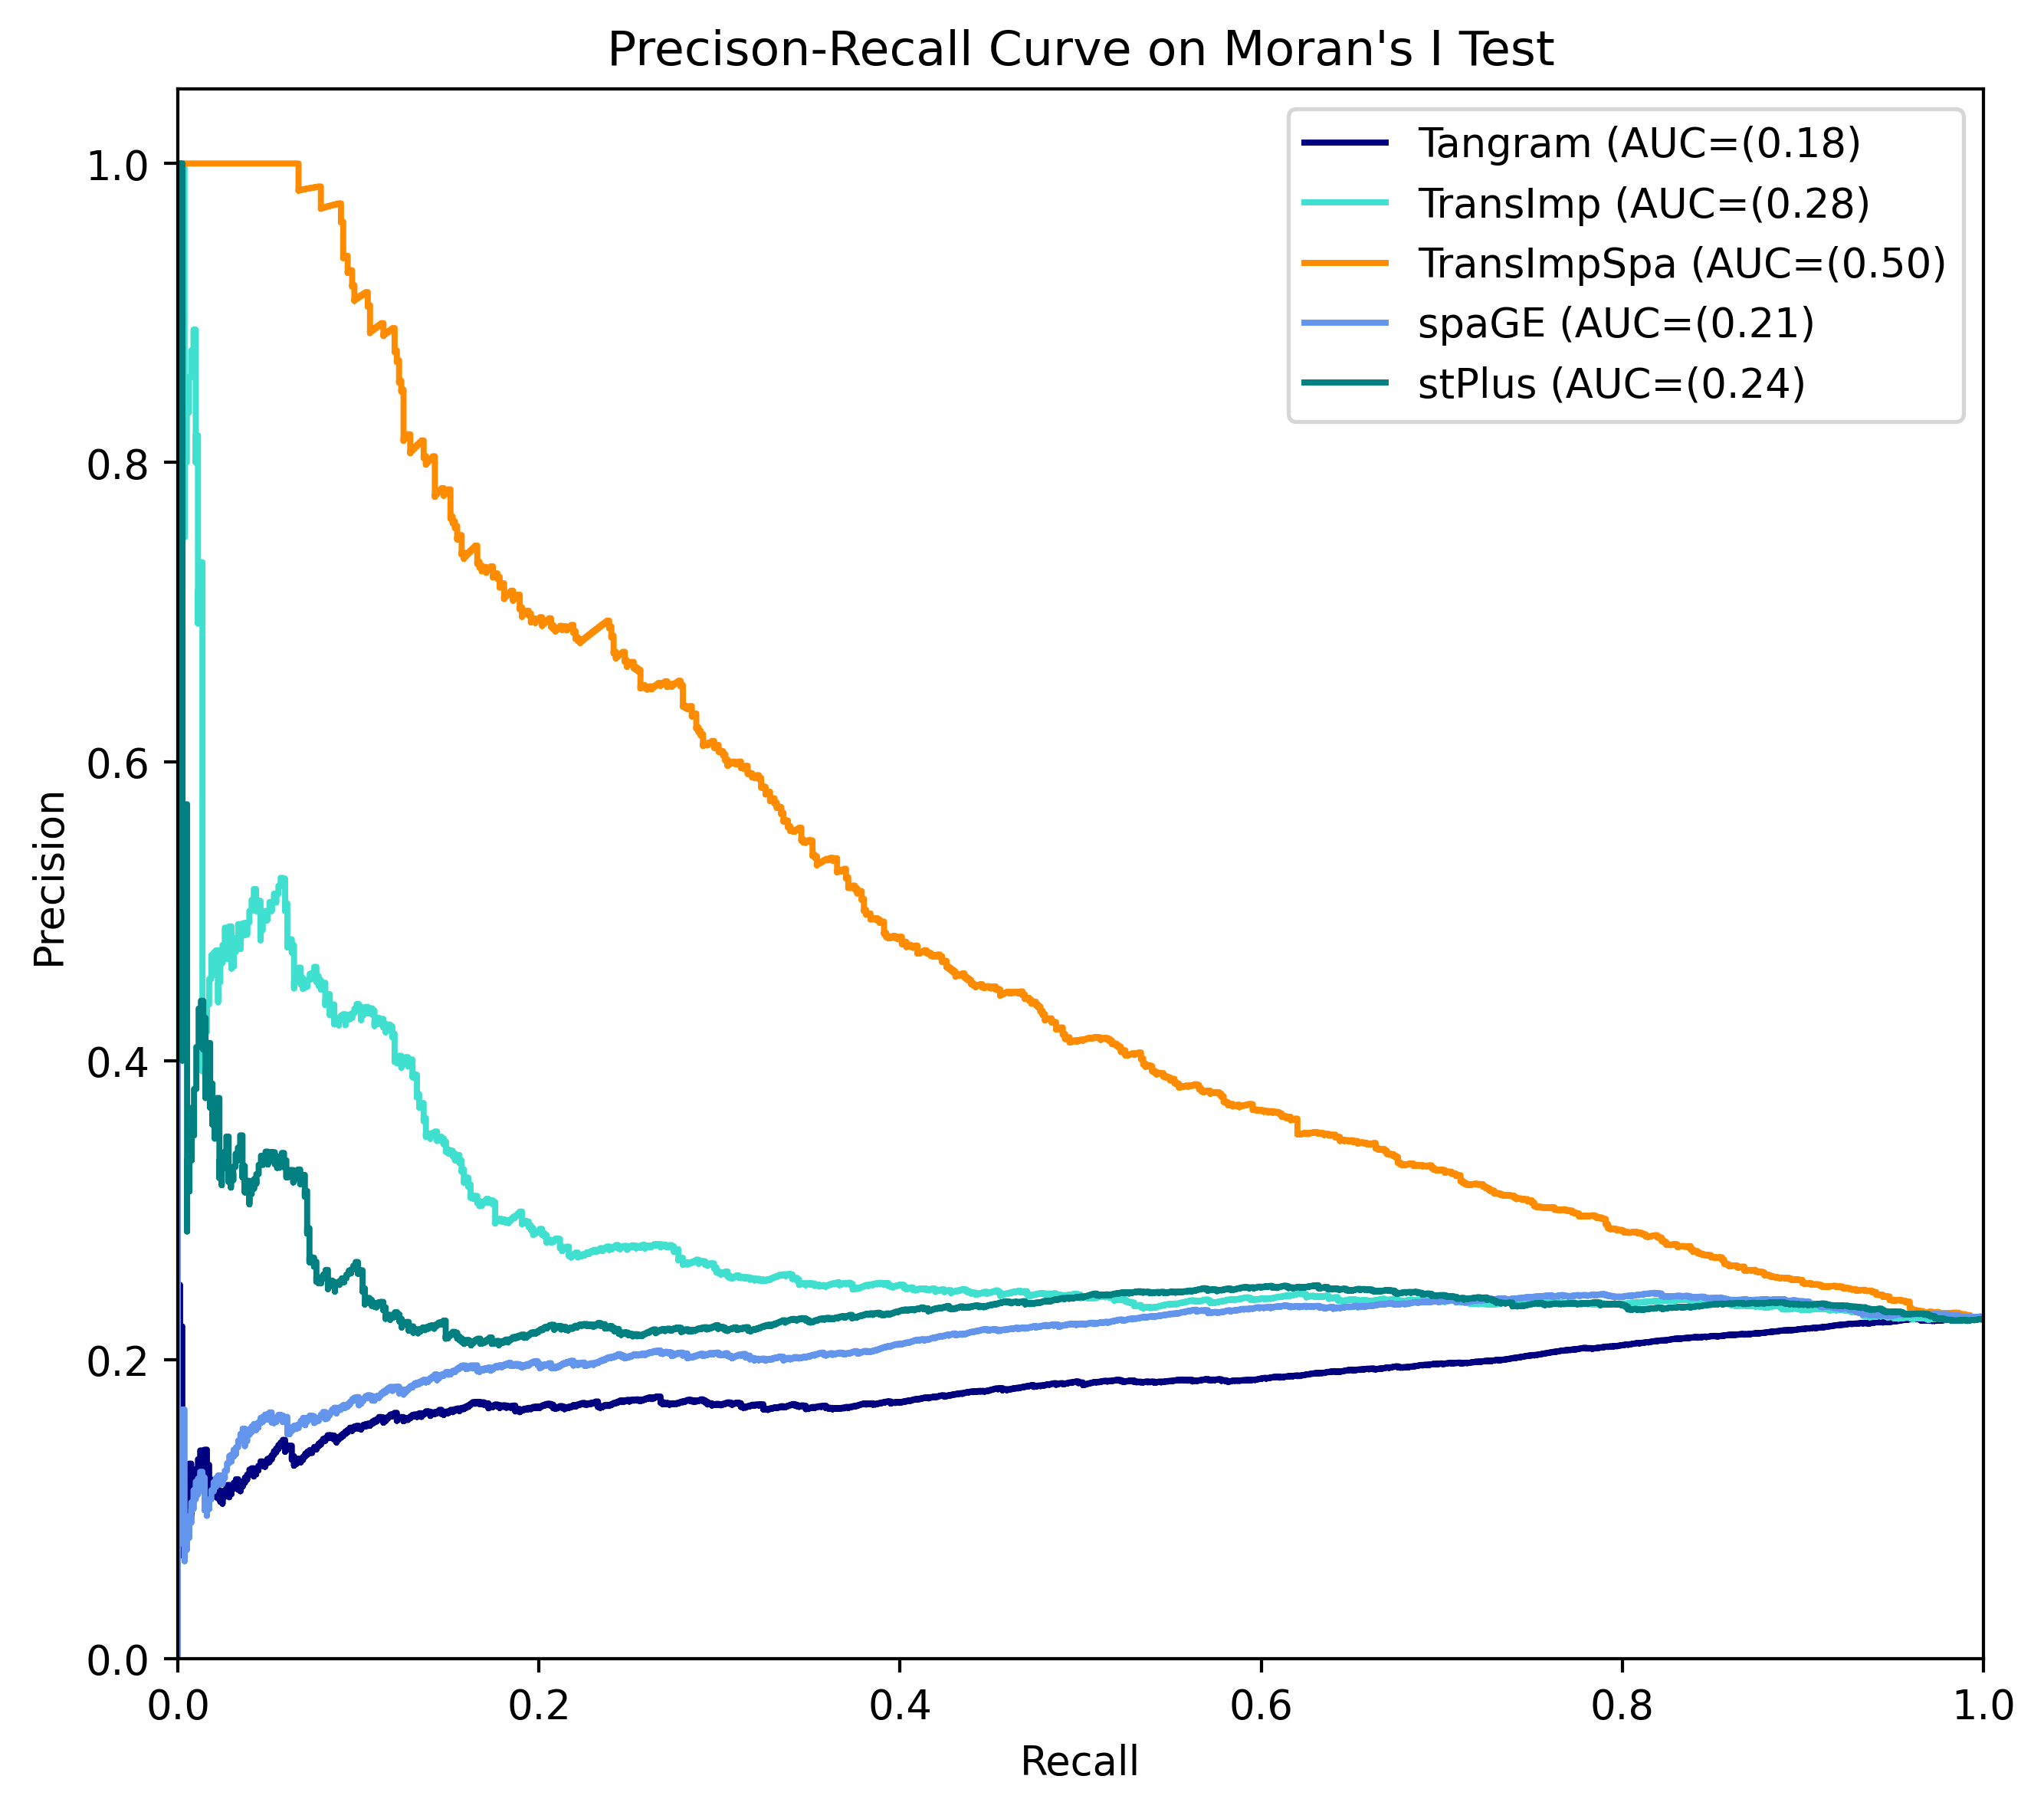

In [12]:
from sklearn import metrics
from matplotlib import pyplot as plt

idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'TransImpClsSpa', 'truth'}: continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, preds_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    score = df_I[method][sel]
    # score = -np.log(df_pval[method][sel] + min(df_pval[method][sel].min() * 1e-6, 1e-300))
    # score[np.isinf(score)] = score[~np.isinf(score)].max()*10
    print(np.isnan(preds_pval).sum())
    # plt.hist(fdr, bins=100)
    print(method)
    preds = preds_pval < thred
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}, Ground Sig/Total ({(truth_pval < thred).sum()}/{truth_pval.shape[0]}), Pred Sig/total ({(preds_pval < thred).sum()}/{preds_pval.shape[0]})')
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "transImpClsSpa", 'truth'}:
        idx += 1
    else:
        continue     
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on Moran's I Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 3546/4517
Tangram
FPR: 0.994156
(TransImp) Valid genes: 3546/4517
TransImp
FPR: 0.938276
(TransImpSpa) Valid genes: 3546/4517
TransImpSpa
FPR: 0.507670
(spaGE) Valid genes: 3546/4517
spaGE
FPR: 0.940102
(stPlus) Valid genes: 3448/4517
stPlus
FPR: 0.000000


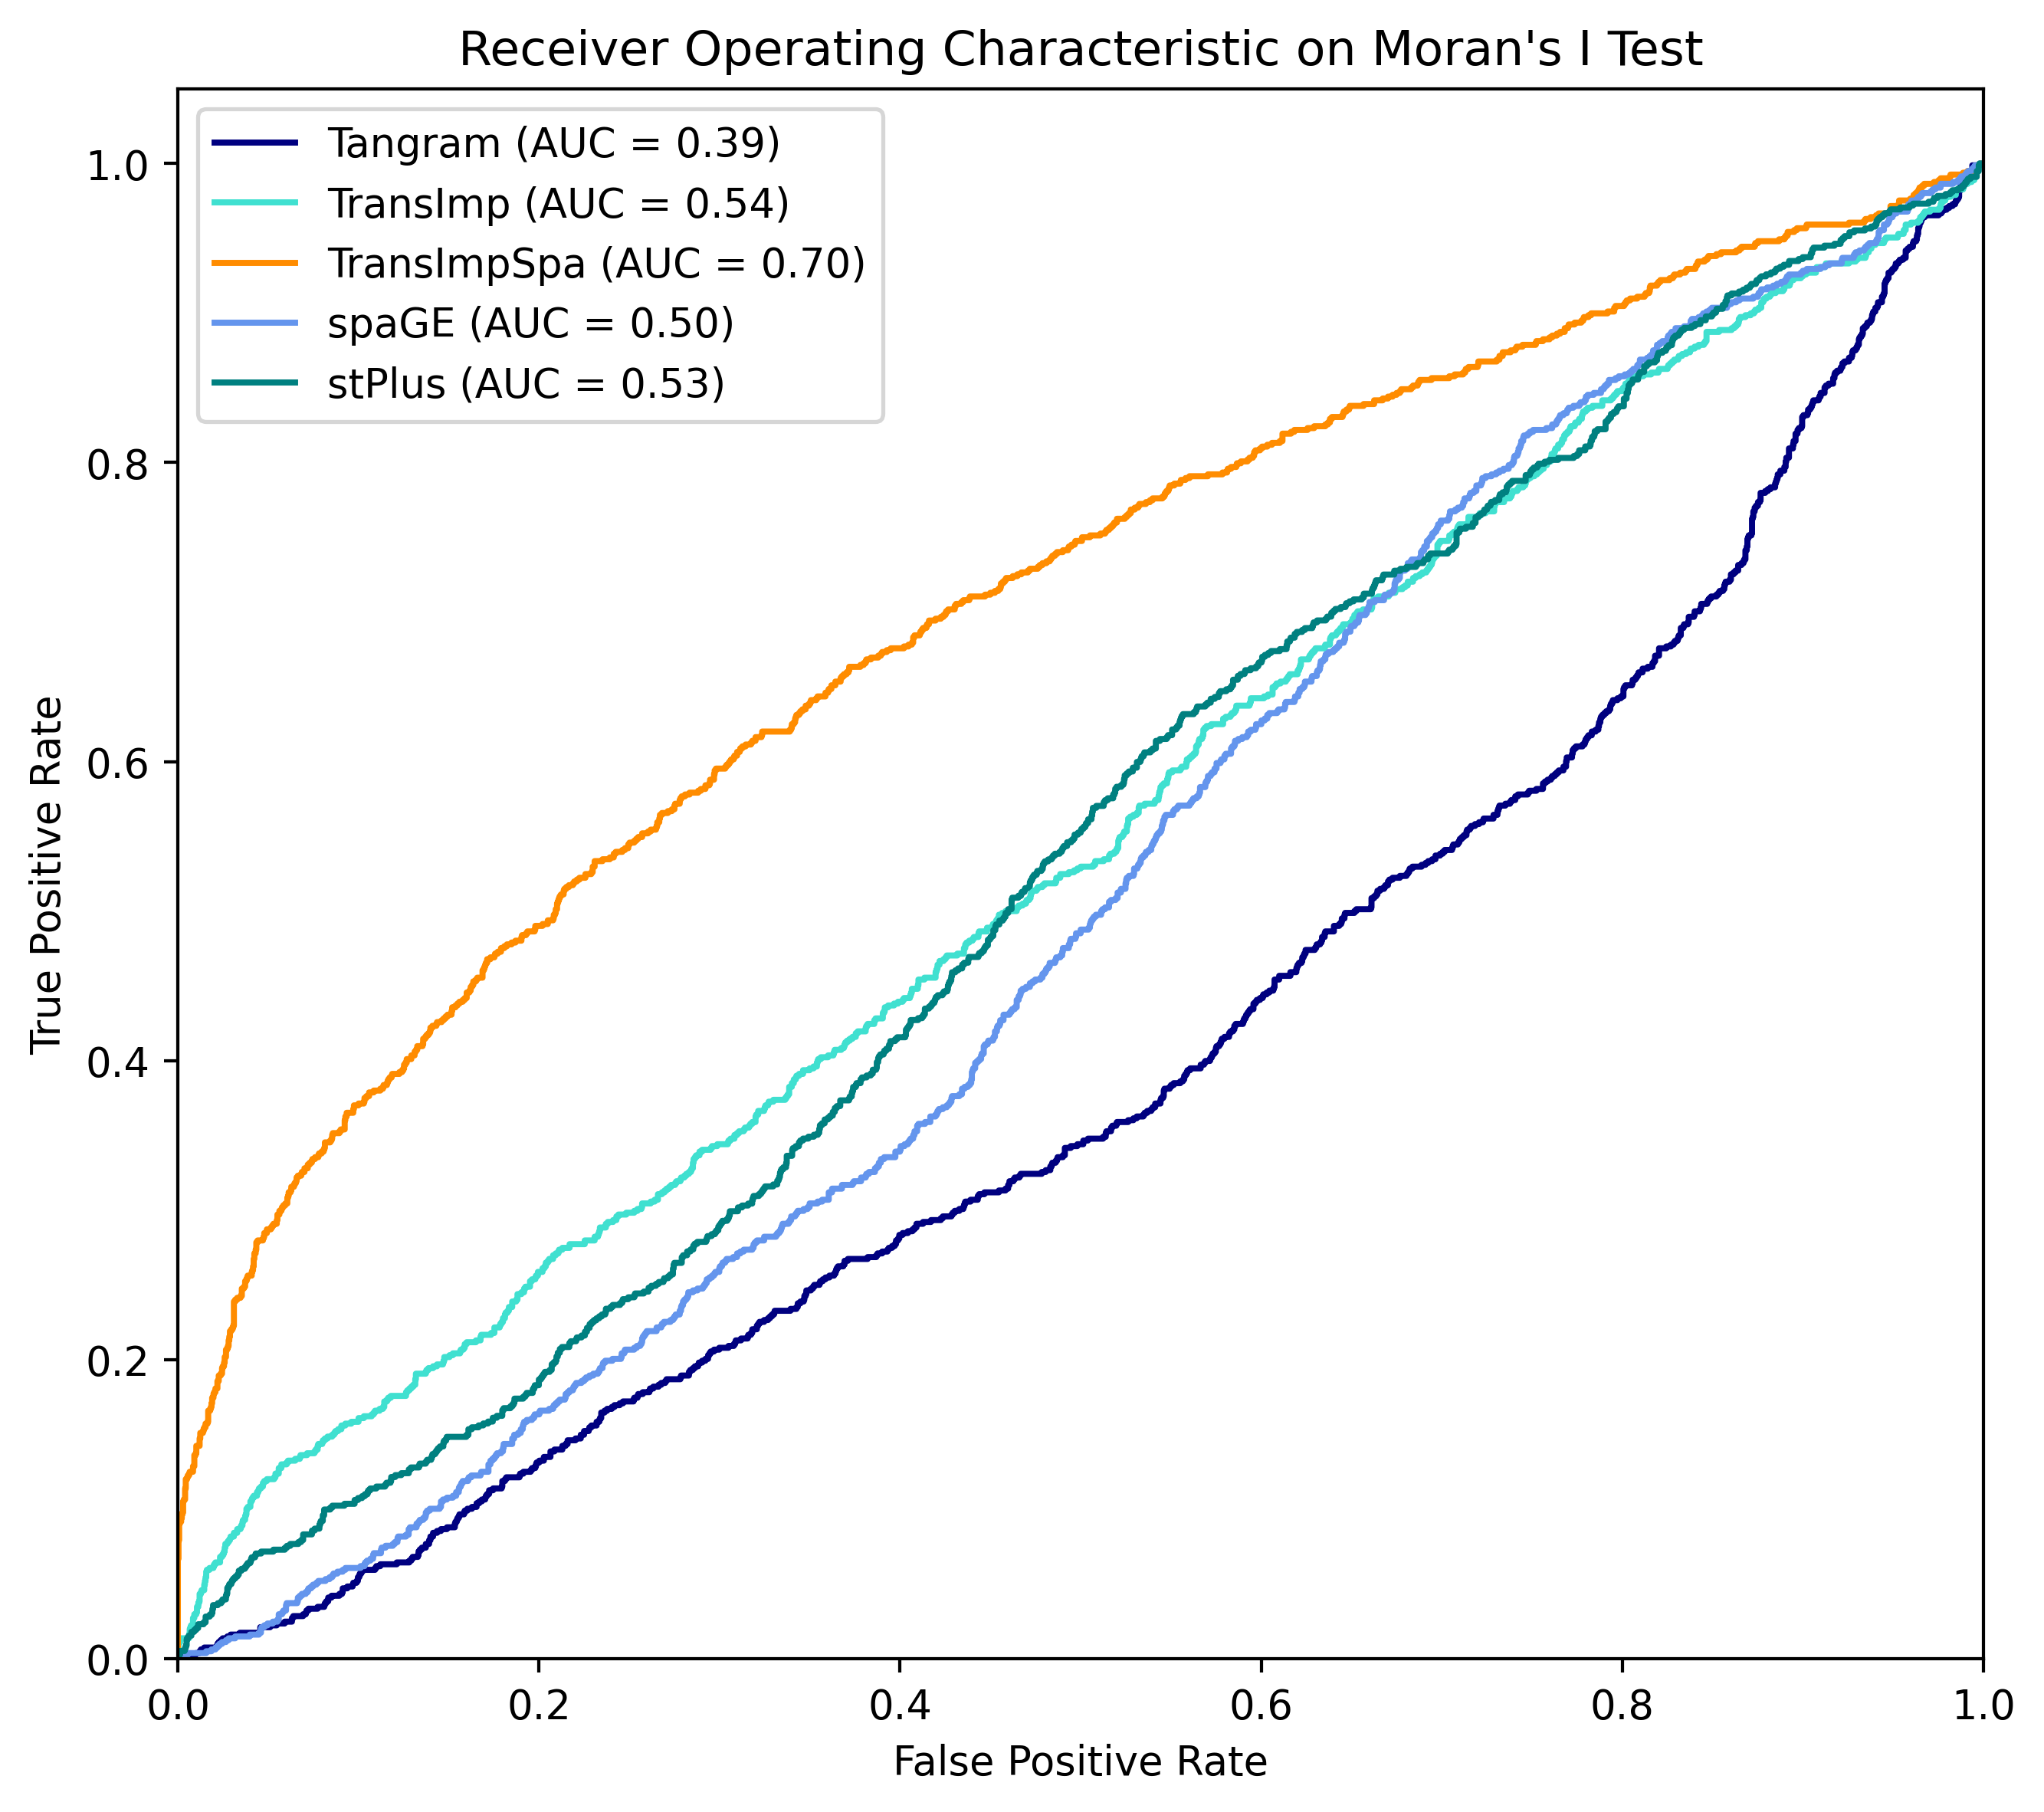

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

<Figure size 2432x1824 with 0 Axes>

In [13]:
fprs = []
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue

    sel = (~np.isnan(df_I['truth'].values) )& (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) 
    
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    score = df_I[method][sel]
    # score = -np.log(df_pval[method][sel] + min(df_pval[method][sel].min() * 1e-6, 1e-300))
    # score[np.isinf(score)] = score[~np.isinf(score)].max()*10    
    print(method)
    preds = method_pval < thred
    
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    
    if not method in {"transImpCls", 'truth',  "transImpClsSpa"}:
        fprs.append({"Method": method, 'False Positive Rate':cm[0][1]/(cm[0][1] + cm[0][0]), "Test": "Moran's I"})
        idx += 1
    else:
        continue
    
    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    plt.figure()
    lw = 2
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    disp.plot(ax=ax, name=f"{method} (AUC = {metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    

ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on Moran's I Test")
ax.legend(loc="best")
plt.show()


(Tangram) Valid genes: 3546/4517
Tangram
FPR: 0.994156
prec: 0.2260449246516918, recl: 0.9839108910891089,  F1: 0.36763005780346825
(TransImp) Valid genes: 3546/4517
TransImp
FPR: 0.938276
prec: 0.23152856715524978, recl: 0.9579207920792079,  F1: 0.3729221874247169
(TransImpSpa) Valid genes: 3546/4517
TransImpSpa
FPR: 0.507670
prec: 0.24333151878062056, recl: 0.5532178217821783,  F1: 0.3379962192816635
(spaGE) Valid genes: 3546/4517
spaGE
FPR: 0.940102
prec: 0.23187108325872874, recl: 0.9616336633663366,  F1: 0.3736475114210147
(stPlus) Valid genes: 3448/4517
stPlus
FPR: 0.000000
prec: 0.0, recl: 0.0,  F1: 0.0
(TransImpCls) Valid genes: 3546/4517
TransImpCls
FPR: 0.996348
prec: 0.22565994890718138, recl: 0.9839108910891089,  F1: 0.36712075733087046
(TransImpClsSpa) Valid genes: 3546/4517
TransImpClsSpa
FPR: 0.671658
prec: 0.23311092577147624, recl: 0.6918316831683168,  F1: 0.34872114784778546


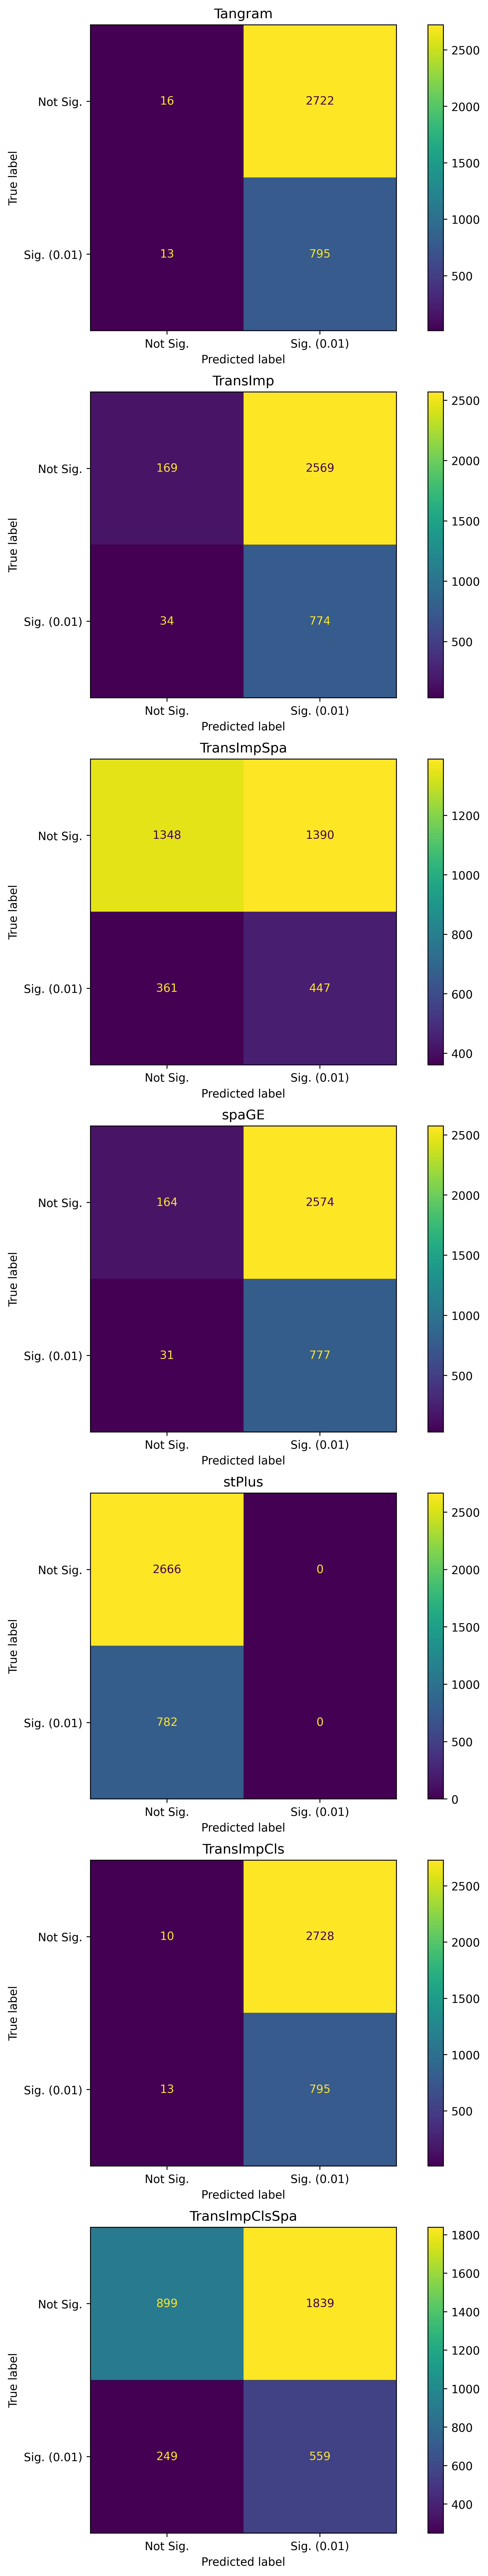

In [14]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in methods:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    # else:
        # continue
    sel = (~np.isnan(df_I['truth'].values) ) & (~np.isnan(df_I[method].values))
    sel = sel & (df_I.truth.values >= 0) # & (df_issig.truth.values == 0)
    # sel = sel & (spa_adata[:, df_I.index.values].uns['moranI'].pval_norm_fdr_bh.values < thred)
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, pred_pval = df_fdr.truth.values[sel], df_fdr[method][sel]
    # score = df_I[method][sel]
    
    print(method)
    preds = pred_pval < thred
    # print("precision ", metrics.precision_score(y < thred, preds))
    # print("recall", metrics.recall_score(y < thred , preds))
    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [15]:
# !Rscript sparkX.r
!/mnt/chenqiao/nfs_share/software/anaconda3/envs/r-environment/bin/Rscript sparkX.r mouseliver5fold

[1] "truth"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2110 
## number of total genes: 4517 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing With Cosine Kernel 5
[1] "stPlus"
## ===== SPARK-X INPUT INFORMATION ==== 
## number of total samples: 2110 
## number of total genes: 4315 
## Running with 10 cores 
## Testing With Projection Kernel
## Testing With Gaussian Kernel 1
## Testing With Gaussian Kernel 2
## Testing With Gaussian Kernel 3
## Testing With Gaussian Kernel 4
## Testing With Gaussian Kernel 5
## Testing With Cosine Kernel 1
## Testing With Cosine Kernel 2
## Testing With Cosine Kernel 3
## Testing With Cosine Kernel 4
## Testing Wi

In [16]:
dict_sparkx_cmbpvals = {}
dict_sparkx_adjpvals = {}
ca_genes = None

for md in methods:
    print(md)
    df = pd.read_csv(f"../../output/sparkx_{ST_name}_{md}.csv", header=0, index_col=0)
    if ca_genes is None:
        ca_genes = df.index.values
    
    shared_gene = np.intersect1d(ca_genes, df.index.values)
    if len(shared_gene) < len(ca_genes):
        miss_gene  = np.setdiff1d(ca_genes, shared_gene)
        df = pd.concat([df, pd.DataFrame({"combinedPval":{g:1.0 for g in miss_gene},"adjustedPval":{g:1.0 for g in miss_gene} })], axis=0)
    dict_sparkx_cmbpvals[md] = df.loc[ca_genes, 'combinedPval']
    dict_sparkx_adjpvals[md] = df.loc[ca_genes, 'adjustedPval']
df_sparkx_cmbpvals = pd.DataFrame(dict_sparkx_cmbpvals)
df_sparkx_adjpvals = pd.DataFrame(dict_sparkx_adjpvals)
df_sparkx_cmbpvals, df_sparkx_adjpvals
    

truth
Tangram
TransImp
TransImpSpa
spaGE
stPlus
TransImpCls
TransImpClsSpa


(                        truth       Tangram      TransImp   TransImpSpa  \
 X0610010F05Rik   1.640302e-01  3.195163e-24  3.823152e-24  8.718979e-09   
 X1110046J04Rik   4.400503e-01  2.909024e-31  7.744973e-02  2.059626e-01   
 X1190005I06Rik   1.630957e-03  2.502616e-09  6.328271e-15  5.608546e-09   
 X1200007C13Rik   3.833620e-01  3.469282e-24  1.258212e-03  1.439768e-01   
 X1500009L16Rik   6.024453e-01  5.578635e-18  4.281998e-05  8.310277e-01   
 ...                       ...           ...           ...           ...   
 mt.Nd2          1.145121e-102  7.501442e-34  2.479808e-42  7.976069e-21   
 mt.Nd3           2.967465e-25  2.253005e-29  1.706611e-31  6.661338e-16   
 mt.Nd4           2.200623e-87  1.770021e-33  1.237453e-39  3.811553e-25   
 mt.Nd4l          1.176541e-06  2.462456e-28  6.220145e-39  9.619336e-23   
 mt.Nd5           1.670276e-18  1.445851e-33  3.431701e-42  1.899376e-23   
 
                        spaGE        stPlus   TransImpCls  TransImpClsSpa  
 X0610010F

(Tangram) Valid genes: 4517/4517
Tangram
FPR: 0.952325
(TransImp) Valid genes: 4517/4517
TransImp
FPR: 0.889150
(TransImpSpa) Valid genes: 4517/4517
TransImpSpa
FPR: 0.735557
(spaGE) Valid genes: 4517/4517
spaGE
FPR: 0.698920
(stPlus) Valid genes: 4517/4517
stPlus
FPR: 0.437764


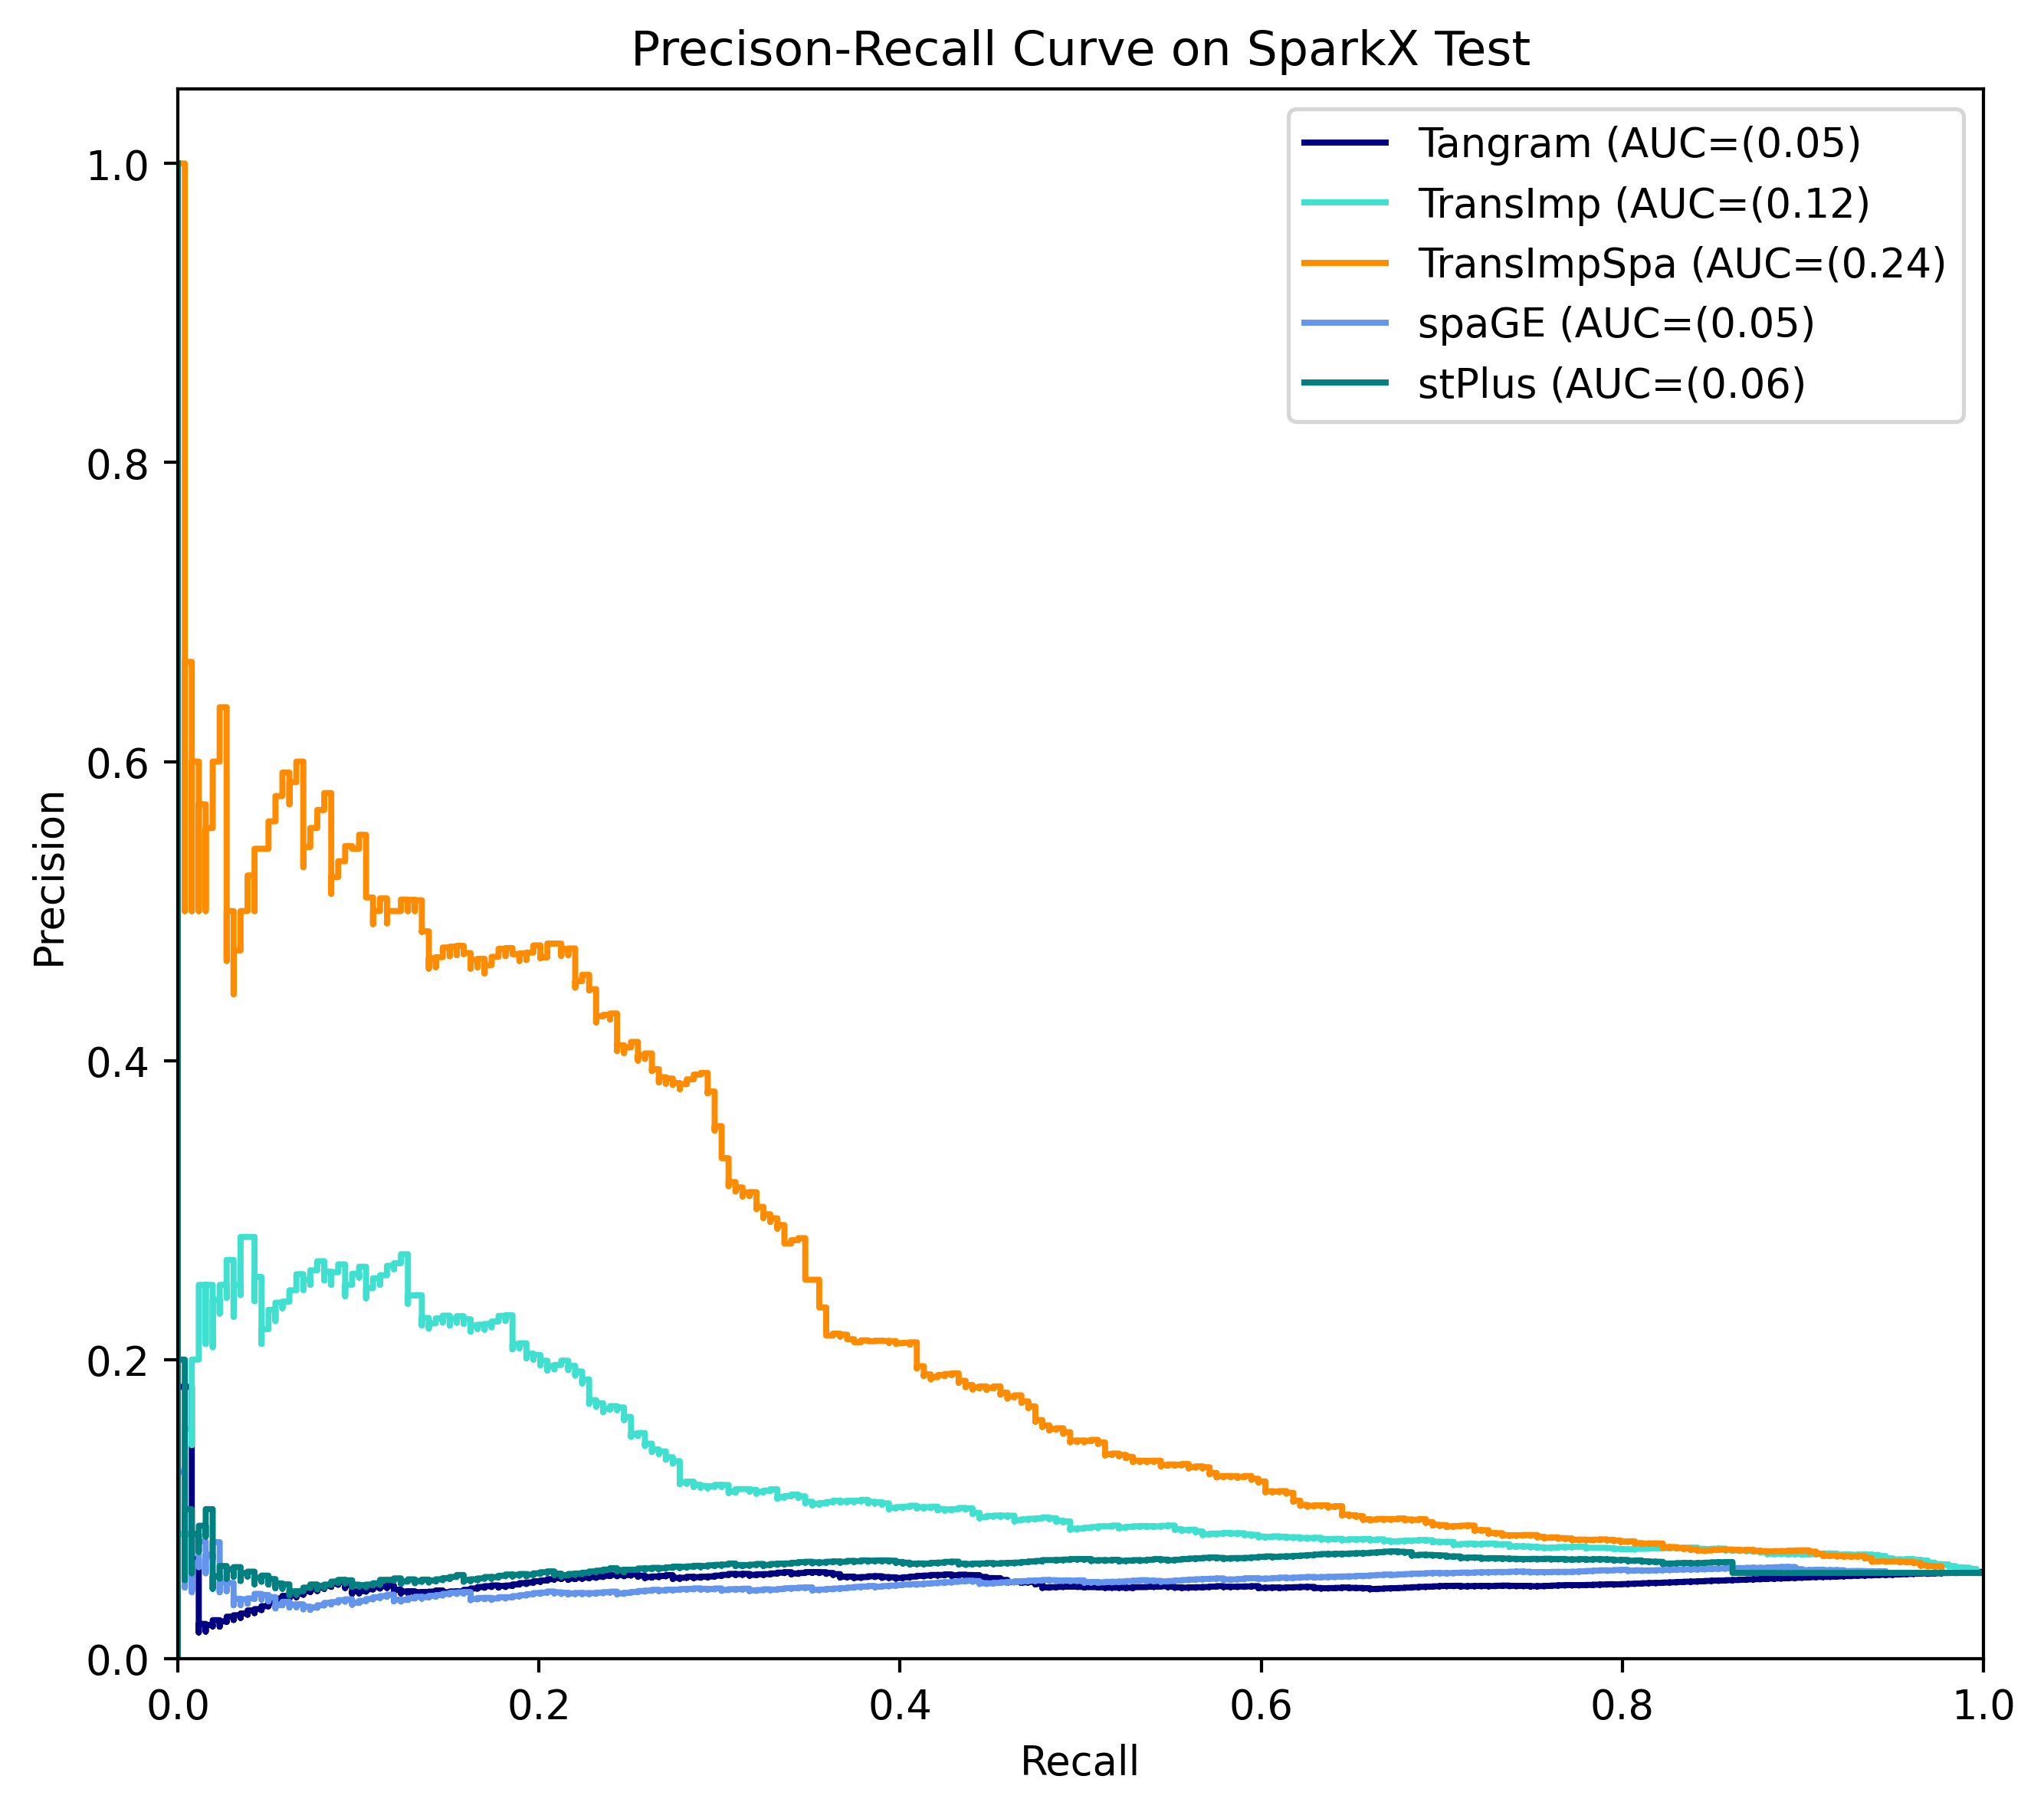

In [17]:
from sklearn import metrics
from matplotlib import pyplot as plt

thred = 0.01
idx = -1
color = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'blue', 'grey']
plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue
    
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-200))
    
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "truth", "transImpClsSpa"}:
        idx += 1
    else:
        continue      
    
    prec, rec, thresholds  = metrics.precision_recall_curve(truth_pval < thred, score, pos_label=1)
       
    disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.average_precision_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Precison-Recall Curve on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 4517/4517
Tangram
FPR: 0.952325
(TransImp) Valid genes: 4517/4517
TransImp
FPR: 0.889150
(TransImpSpa) Valid genes: 4517/4517
TransImpSpa
FPR: 0.735557
(spaGE) Valid genes: 4517/4517
spaGE
FPR: 0.698920
(stPlus) Valid genes: 4517/4517
stPlus
FPR: 0.437764


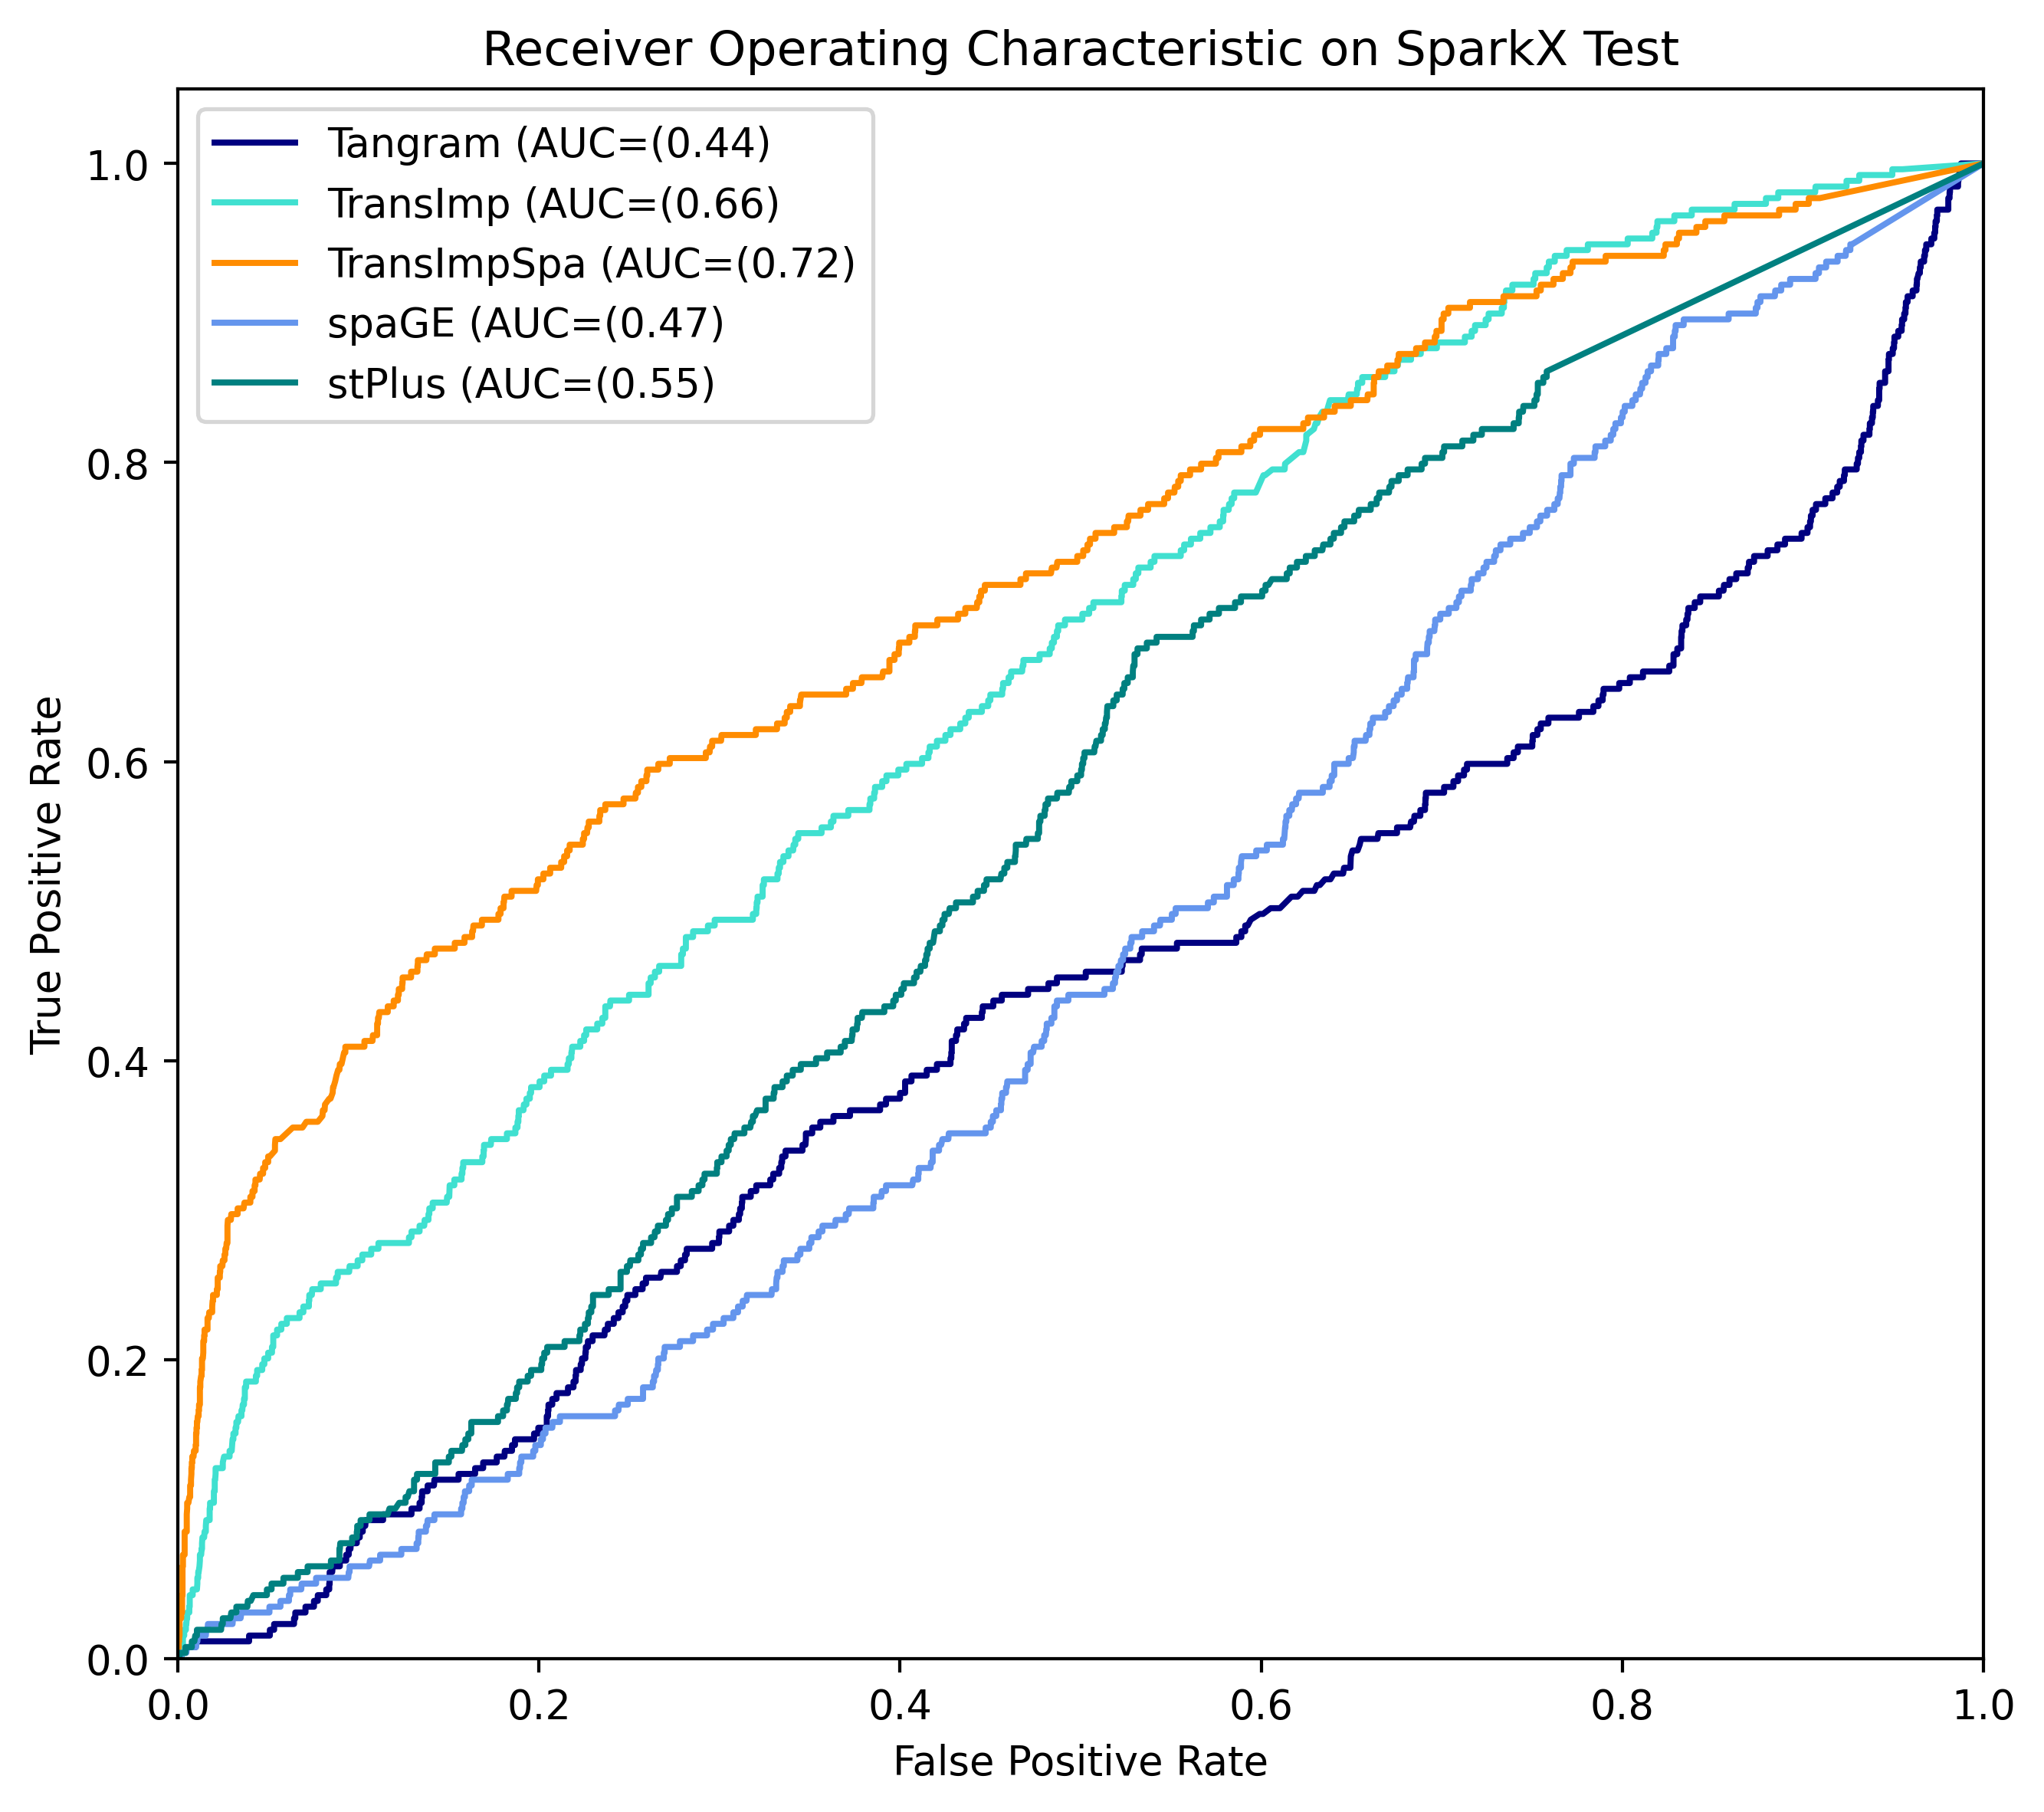

In [18]:
from sklearn import metrics
from matplotlib import pyplot as plt
thred = 0.01
idx = -1

plt.rcParams["figure.dpi"] = 380
_, ax = plt.subplots(figsize=(8, 7))
for method in df_corr.columns:
    # predict zero, 1-score
    if method in {'TransImpCls', 'truth', 'TransImpClsSpa'}: continue
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    # score =  1 - df_sparkx_cmbpvals[method][sel].values
    score = -np.log(df_sparkx_adjpvals[method][sel].values + min(np.min(df_sparkx_adjpvals[method][sel].values) * 1e-3, 1e-200))
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    if not method in {"transImpCls", "truth", "transImpClsSpa"}:
        idx += 1
    else:
        continue      

    fpr, tpr, thresholds  = metrics.roc_curve(truth_pval < thred, score, pos_label=1)
    
    auc_score = metrics.auc(fpr, tpr)
    
    disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
    
    disp.plot(ax=ax, name = f"{method} (AUC=({metrics.roc_auc_score(truth_pval < thred, score):.2f})", color=color[idx])
    
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

ax.set_title(f"Receiver Operating Characteristic on SparkX Test")
ax.legend(loc="best")
plt.show()

(Tangram) Valid genes: 4517/4517
Tangram
FPR: 0.952325
prec: 0.0534547152194211, recl: 0.8841698841698842,  F1: 0.10081443979749063
(TransImp) Valid genes: 4517/4517
TransImp
FPR: 0.889150
prec: 0.06287128712871287, recl: 0.9806949806949807,  F1: 0.11816701558501977
(TransImpCls) Valid genes: 4517/4517
TransImpCls
FPR: 0.976045
prec: 0.05845038513819665, recl: 0.9961389961389961,  F1: 0.11042157072544405
(TransImpClsSpa) Valid genes: 4517/4517
TransImpClsSpa
FPR: 0.904180
prec: 0.06211936662606577, recl: 0.9845559845559846,  F1: 0.11686526122823097
(TransImpSpa) Valid genes: 4517/4517
TransImpSpa
FPR: 0.735557
prec: 0.07007125890736342, recl: 0.9111969111969112,  F1: 0.13013509787703337
(spaGE) Valid genes: 4517/4517
spaGE
FPR: 0.698920
prec: 0.057034220532319393, recl: 0.694980694980695,  F1: 0.10541727672035138
(stPlus) Valid genes: 4517/4517
stPlus
FPR: 0.437764
prec: 0.06566416040100251, recl: 0.5057915057915058,  F1: 0.11623779946761313


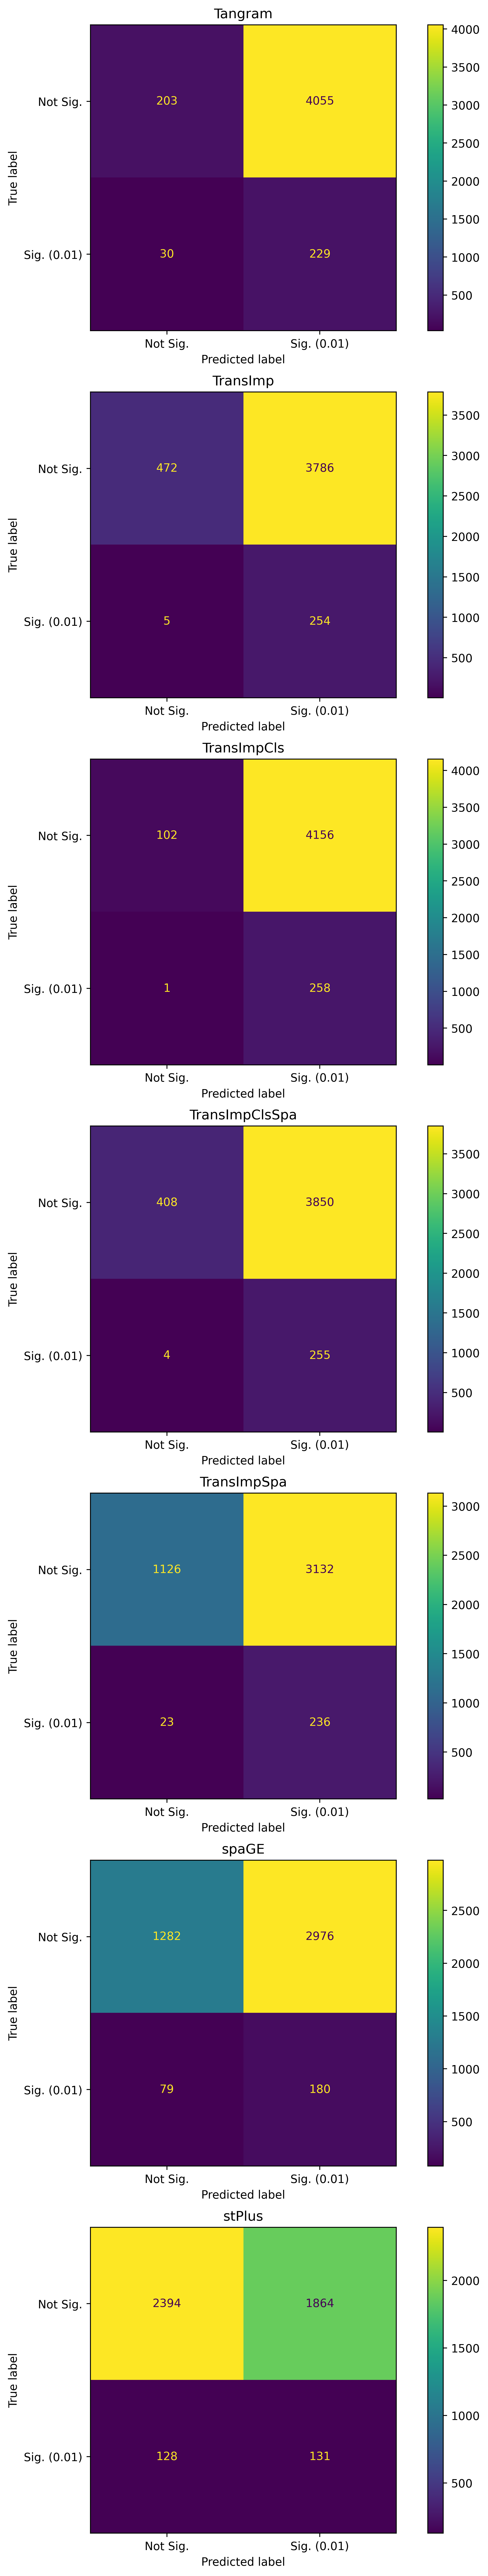

In [19]:
from sklearn import metrics
from matplotlib import pyplot as plt
# tred = 1e-2

_, axs = plt.subplots(7, figsize=(10, 40))
idx = -1
for method in df_corr.columns:
    # predict zero, 1-score
    if method == "truth": continue
    # if not method in {"transImpCls", "transImpute", "transImpClsSpa"}:
    idx += 1
    sel = (~np.isnan(df_sparkx_adjpvals['truth'].values) ) & (~np.isnan(df_sparkx_adjpvals[method].values))
    print(f'({method}) Valid genes: {sel.sum()}/{sel.shape[0]}')
    truth_pval, method_pval = df_sparkx_adjpvals.truth.values[sel], df_sparkx_adjpvals[method][sel]
    score =  1 - df_sparkx_adjpvals[method][sel].values
    
    print(method)
    preds = method_pval < thred

    cm = metrics.confusion_matrix(truth_pval < thred, preds, labels=[0, 1])
    print(f"FPR: {cm[0][1]/(cm[0][1] + cm[0][0]):.6f}")
    print(f"prec: {metrics.precision_score(truth_pval < thred, preds)}, recl: {metrics.recall_score(truth_pval < thred, preds)},  F1: {metrics.f1_score(truth_pval < thred, preds)}")
    disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=["Not Sig.", f"Sig. ({thred})"])
    disp.plot(ax=axs[idx])
    axs[idx].set_title(f"{method}")

plt.show()

In [20]:
from scipy import sparse
def merge_data(imp_adata, adata):
    valid_genes = [g for g in adata.var_names if g not in imp_adata.var_names]
    print(f"Valid genes: {len(valid_genes)}, Ex genes: {imp_adata.shape[1]}")
    X = adata[:, valid_genes].X
    if sparse.issparse(X):
        X = X.toarray()
    X = np.hstack([X, imp_adata.X])
    m_adata = sc.AnnData(X, dtype=np.float32)
    m_adata.var_names = np.concatenate([valid_genes, imp_adata.var_names.values])
    return m_adata
def read_data(imp_adatas):
    sc.read_csv(f"../../data/ST/MouseLiver/SCP2046/expression/processed_c1.csv.gz").T.copy()
    adatas = {}
    for method in methods:
        adatas[method] = merge_data(imp_adatas[method], spa_adata)
        adatas[method].obsm['spatial'] = spa_adata.obsm['spatial'].copy()
    return adatas

m_adatas = read_data(dict_adata)

Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517
Valid genes: 493, Ex genes: 4517


In [21]:
def spatialdm(adata, spec, l):
    sdm.weight_matrix(adata, n_nearest_neighbors=6, l=l, cutoff=0.2, single_cell=False)
    # find overlapping LRs from CellChatDB
    sdm.extract_lr(adata, spec, min_cell=0)
    # global Moran selection
    # print(adata.uns)
    # print(adata)
    cp_adata = None
    try:
        sdm.spatialdm_global(adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(adata, method='z-score', fdr=True, threshold=0.1)        
    except Exception as e:
        # print(e)
        cp_adata = adata.copy()
        sdm.extract_lr(cp_adata, spec, min_cell=1)
        sdm.spatialdm_global(cp_adata, 10, specified_ind=None, method='both', nproc=10)
        sdm.sig_pairs(cp_adata, method='z-score', fdr=True, threshold=0.1)
    # select significant pairs
    if not cp_adata is None:
        full_set = adata.uns['geneInter'].interaction_name
        # print(np.intersect1d(full_set, cp_adata.uns['global_res'].index.values))
        full_global_res = cp_adata.uns['global_res'].copy()
        full_global_res['global_I'] = cp_adata.uns['global_I'].copy()
        for pair in full_set:
            if pair not in cp_adata.uns['global_res'].index.values:
                # z	perm_pval	fdr	selected
                full_global_res = pd.concat([full_global_res, pd.DataFrame({
                    "Ligand0":{pair:pair.split("_")[0]},
                    "Receptor0":{pair:pair.split("_")[1]},
                    "Receptor1":{pair:None},
                    "z_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "z":{pair:np.random.rand()*0.01},
                    "perm_pval":{pair:0.99 + np.random.rand() * 0.01},
                    "fdr":{pair:0.99 + np.random.rand() * 0.01},
                    "selected":{pair:False},
                    "global_I":{pair:np.random.rand() * 1e-6},
                })])
        # print(np.intersect1d(full_global_res.index, cp_adata.uns['global_res'].index.values))        
        adata.uns['global_res'] = full_global_res.loc[adata.uns['geneInter'].interaction_name].copy()
        adata.uns['global_I'] = full_global_res.global_I.values
        
        
    valid_genes = [True if l != r else False for l,r in zip(adata.uns['global_res'].Ligand0, adata.uns['global_res'].Receptor0)]
    print(len(valid_genes), adata.uns['global_res'].shape[0])
    sel = adata.uns['global_res'].index[valid_genes]
    adata.uns['global_res'] = adata.uns['global_res'].loc[sel]
    adata.uns['global_I'] = adata.uns['global_I'][valid_genes]
    adata.uns['global_res'].sort_values(by='fdr')
    print(adata.uns['global_res'].shape)
for md in m_adatas:
    spatialdm(m_adatas[md], spec, 20)    

100%|██████████| 10/10 [00:00<00:00, 37.21it/s]


332 332
(323, 11)


100%|██████████| 10/10 [00:00<00:00, 37.06it/s]


332 332
(323, 11)


100%|██████████| 10/10 [00:00<00:00, 41.98it/s]


332 332
(323, 11)


100%|██████████| 10/10 [00:00<00:00, 38.77it/s]


332 332
(323, 11)


100%|██████████| 10/10 [00:00<00:00, 39.70it/s]


332 332
(323, 11)


100%|██████████| 10/10 [00:00<00:00, 42.39it/s]


332 332
(323, 12)


100%|██████████| 10/10 [00:00<00:00, 38.01it/s]


332 332
(323, 11)


100%|██████████| 10/10 [00:00<00:00, 34.64it/s]

332 332
(323, 11)


In [22]:
import pickle
with open(f"../../output/{ST_name}_spatialdm.pkl", 'wb') as outfile:
    pickle.dump(m_adatas, outfile)

Tangram # 262 pairs, # sig pairs: (Truth): 24, (Preds) 112
TransImp # 262 pairs, # sig pairs: (Truth): 24, (Preds) 109
TransImpSpa # 262 pairs, # sig pairs: (Truth): 24, (Preds) 102
spaGE # 262 pairs, # sig pairs: (Truth): 24, (Preds) 87
stPlus # 262 pairs, # sig pairs: (Truth): 24, (Preds) 78
TransImpCls # 262 pairs, # sig pairs: (Truth): 24, (Preds) 112
TransImpClsSpa # 262 pairs, # sig pairs: (Truth): 24, (Preds) 104


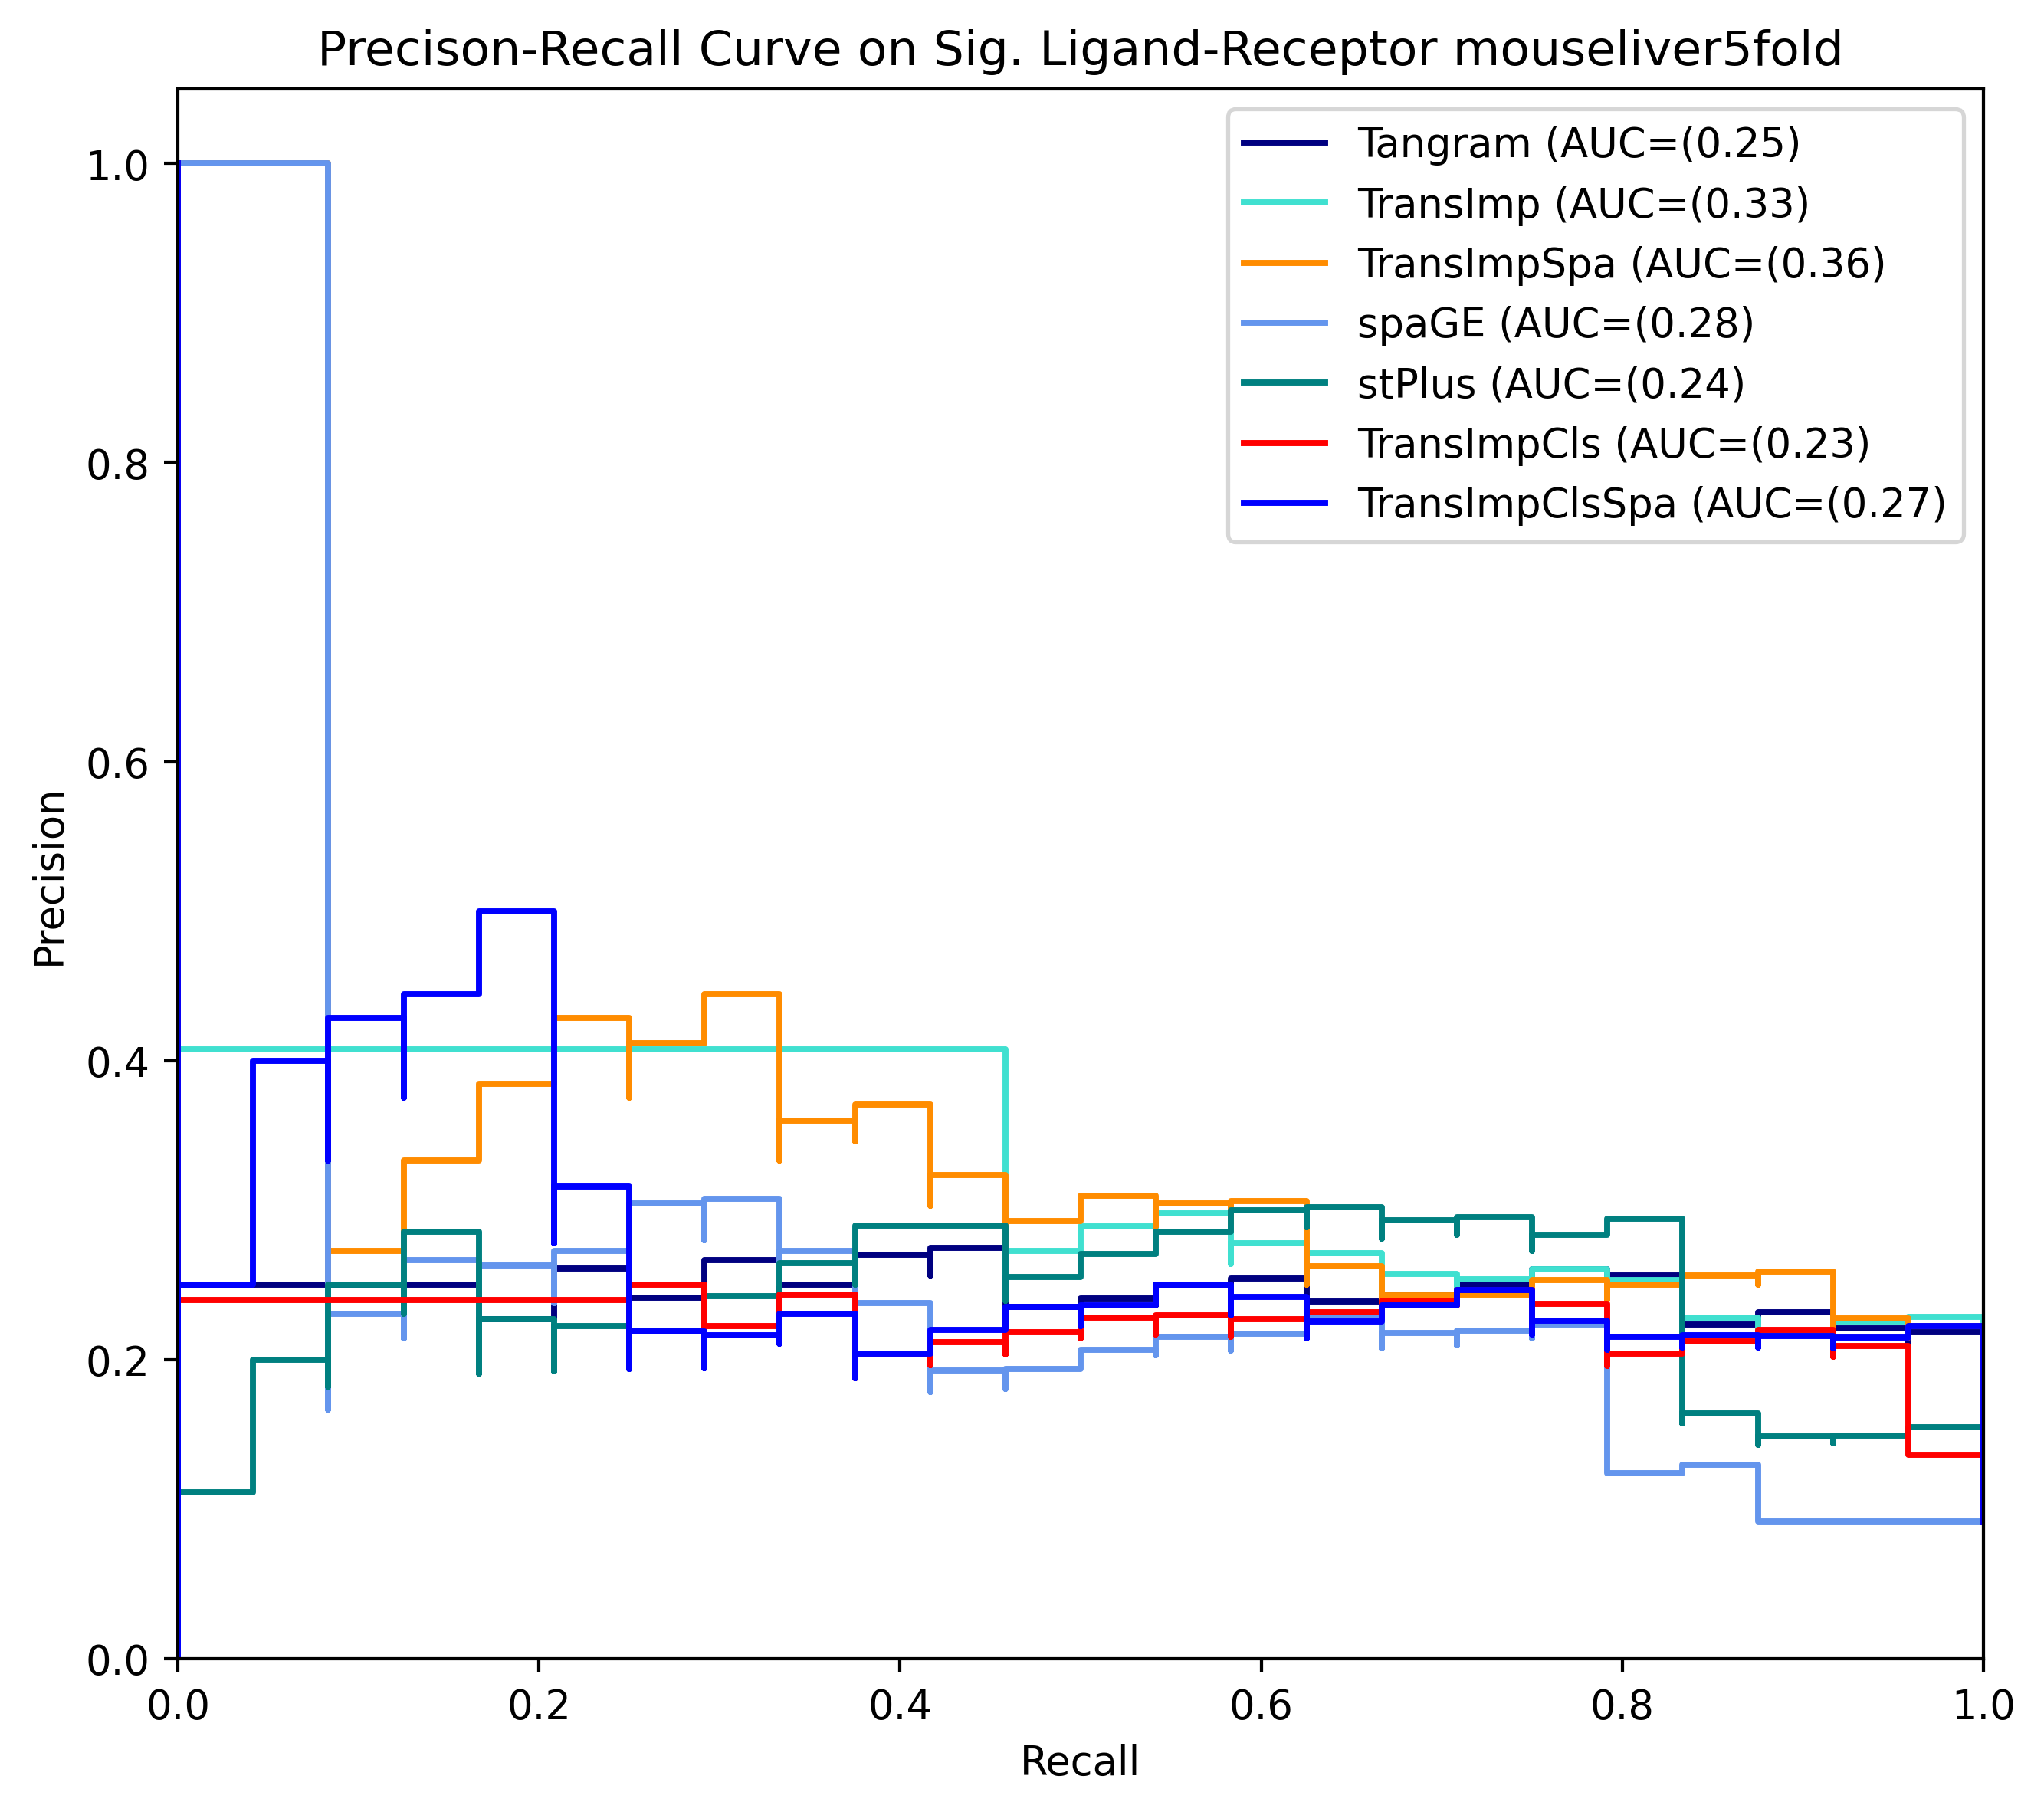

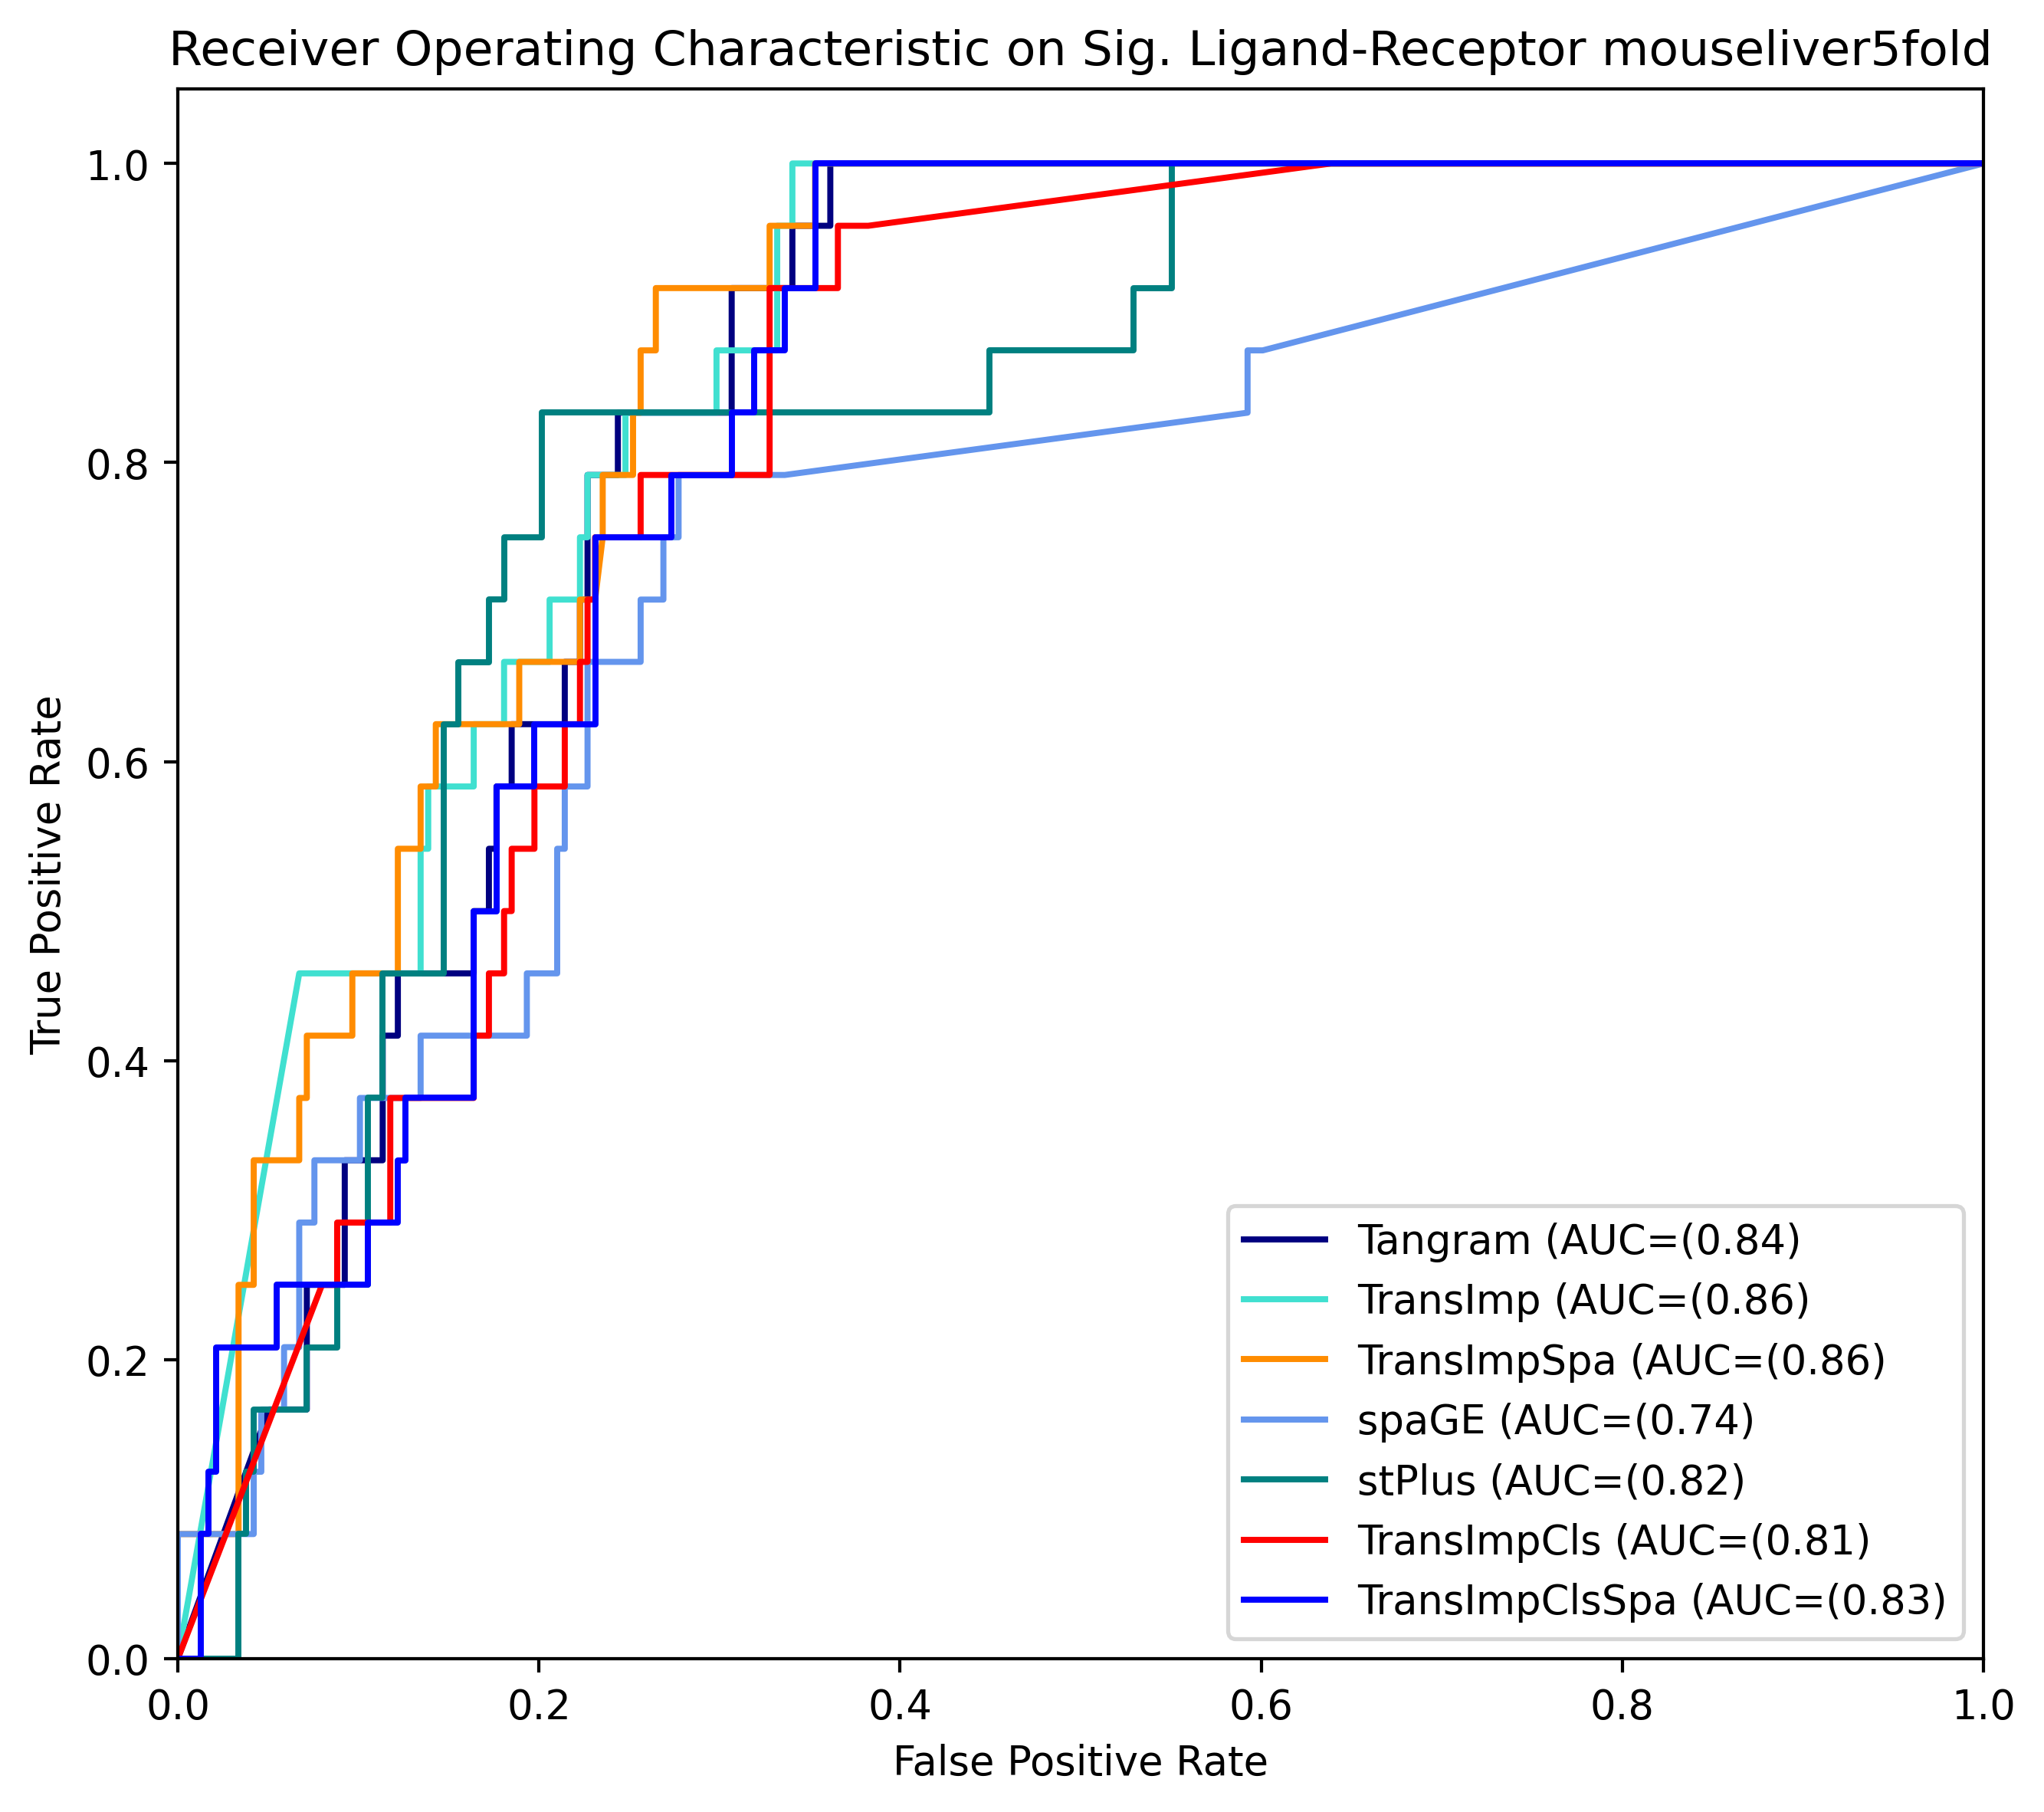

In [23]:
def precision_recall_curve(adatas, dataset_name):
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in methods:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        print(f"{md} # {len(genes)} pairs, # sig pairs: (Truth): {truth_res.loc[genes].selected.values.sum()}, (Preds) {adatas[md].uns['global_res'].loc[genes].selected.values.sum()}")
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(adatas[md].uns['global_res'].loc[genes].fdr.values)
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + min(np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # new_scores = list(range(len(score)))
        # score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # plt.hist(score, bins=100);plt.show()
        # score = expit(score)
        # plt.hist(score, bins=100)
        # plt.show()
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        
        prec, rec, thresholds  = metrics.precision_recall_curve(y, score, pos_label=1)
        
        disp = metrics.PrecisionRecallDisplay(precision=prec, recall=rec)   
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.average_precision_score(y, score):.2f})", color=color[idx])
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Precison-Recall Curve on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()   
    
def roc_curve(adatas, dataset_name):     
    _, ax = plt.subplots(figsize=(8, 7))
    idx = -1
    for md in methods:
        if md == "truth": continue
        if md in {'transImpCls', 'transImpClsSpa'}: continue
        idx += 1
        truth_res = adatas['truth'].uns['global_res'].loc[adatas['truth'].uns['global_I'] >= 0].copy()
        genes = np.intersect1d(truth_res.index, adatas[md].uns['global_res'].index)
        if len(genes) < len(truth_res.index):
            print(f"{md} Fewer genes than truth: {len(genes)} vs {len(truth_res.index)}")
        y = truth_res.loc[genes].selected.values
        # score = 1 - adatas[md].uns['global_res'].loc[genes].fdr.values
        # print(np.max(adatas[md].uns['global_res'].loc[genes].fdr.values), np.min(adatas[md].uns['global_res'].loc[genes].fdr.values))
        score =  - np.log(adatas[md].uns['global_res'].loc[genes].fdr.values + min(np.min(adatas[md].uns['global_res'].loc[genes].fdr.values)/1000, 1e-500))
        score[np.isinf(score)] = score[~np.isinf(score)].max()*10
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # new_scores = list(range(len(score)))
        # score = np.array([new_scores[idx] for idx in np.argsort(score)])
        # adatas[md].uns['global_res']['global_I'] = adatas[md].uns['global_I']
        # score = adatas[md].uns['global_res'].loc[genes].global_I.values
        # score = expit(score)
        fpr, tpr, thresholds  = metrics.roc_curve(y, score, pos_label=1)
        
        auc_score = metrics.auc(fpr, tpr)
        
        disp = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr)
        
        disp.plot(ax=ax, name = f"{md} (AUC=({metrics.roc_auc_score(y, score):.2f})", color=color[idx])
        
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])

    ax.set_title(f"Receiver Operating Characteristic on Sig. Ligand-Receptor {dataset_name}")
    ax.legend(loc="best")
    plt.show()
    

precision_recall_curve(m_adatas, ST_name)
roc_curve(m_adatas, ST_name)
